# CFRM 521 - Final Report

#### By: Wooseok (Jeff) Choi, Max Black, Steve Demirev, Ilse Schmitz, Jasmine Kuo

----

# Introduction

Pricing options is essential for financial institutions to assess the fair value and risk associated with these derivatives. Accurate pricing supports informed investment decisions and enables effective hedging strategies, inaccurate pricing can potentially lead to severe financial losses. Although option pricing is complex, even relatively simple models can achieve a high degree of accuracy in certain scenarios. Several well-established models exist for pricing options, including the Black-Scholes model, the Heston model, and Dupire’s local volatility model. More recently, the rise of machine learning has spurred a growing body of research focused on using data-driven methods—such as neural networks, support vector regression, and decision trees—for option pricing. In this paper, we investigate the efficacy of several common machine learning techniques in pricing American call options.

There is a large body of research available regarding the use of machine learning for options pricing. Papers like Djagba & Ndizihiwe (2024) discuss shortfalls of the Black Scholes model in pricing American options, struggling to appropriately model early exercising and the non-linear payoff structure. The authors apply LSTM and GRU, both types of recurrent neural networks, to better model these relationships. This paper is one of many in a trend of using deep learning techniques to model to tackle complex financial tasks, where traditional models have fallen short.

Ivașcu (2021) identifies similar weaknesses in many parametric models, citing the unrealistic assumptions made about factors like volatility, touching on the importance of accurate options pricing and highlighting the massive losses featured commonly in economic news at that time as a result. In this paper the author evaluates the performance of various machine learning models, such as support vector regression, neural networks and ensemble methods. He finds that machine learning methods outperform the Black-Scholes model with gradient boosting and random forests outperforming SVR and neural networks. 

In our analysis we will apply similar techniques, including neural networks, support vector regression, gradient boosting, random forests and K nearest neighbors regression. Each of these methods is appropriate because it enables us to capture non-linear relationships in high dimensional data. We aim to show that even in very simple forms these models are able to accurately predict prices of American call options, taking advantage of these models' inherent ability to model the complex interaction between our variables. 

### References

Djagba, P., & Ndizihiwe, C. (2024). Pricing American options using machine learning algorithms. arXiv. https://doi.org/10.48550/arXiv.2409.03204

Ivașcu, C.-F. (2021). Option pricing using machine learning. Expert Systems with Applications, 163, 113799. https://doi.org/10.1016/j.eswa.2020.113799

# Data: Historical Options and Stock prices from February 2013

### Original Data Source

The original data for this project is sourced from https://optiondata.org/. They have graciously provided free sample datasets for option prices and stock prices from January 2013 to June 2013. The data we will be using is from the month of February 2013 located in the `2013-02.zip` file located on their website.

### Data Preprocessing

The dataset we will be using is fairly large, there are 19 trading days in the month of February 2013 and two different csv files for each day, the first being the options data and the second being the stock price data. 

To simplify this, we will first join the two datasets through the `symbol` column in the stocks files, and the `underlying` column in the options files. This will allow us to access the data for both in a single file for our features later.

After reviewing the files, we found there were around 500,000 rows for 3800 unique tickers on each trading day, with 19 different days that meant we were looking at close to 9.5 million rows of data. Training machine learning algorithms on this much data will take a very long time, so to minimize this effect, we decided to filter the data to a subset of S&P 100 stocks as of February 1st 2013 and filter the options to call options only, allowing us to train our models within a reasonable time-frame.

Lastly, since our original options data set contained bid and ask prices, we engineered a new feature named `mid_price` which contains the average of the two, and will be evaluated as the price of the option.

Below I've attached a code chunk which displays the filtering we performed. (Please note this won't work on your machine unless you've modified the directories with the location of the files on your own machine):

```
import numpy as np 
import pandas as pd
import os

def combine_options_data(options_data, stock_data):
    options_data['mid_price'] = (options_data['bid'] + options_data['ask'])/2
    combined_df = options_data.merge(stock_data, 
                                     left_on = "underlying", right_on = "symbol",
                                     suffixes=('', '_stock'))
    combined_df = combined_df.drop(columns=['symbol'])
    return combined_df

def combine_new_data(date):
    options = pd.read_csv(f"/home/steve/Downloads/CFRM_521/ProjectData/2013-02/{date}options.csv")
    stocks = pd.read_csv(f"/home/steve/Downloads/CFRM_521/ProjectData/2013-02/{date}stocks.csv")
    return combine_options_data(options, stocks)
        
url = "https://web.archive.org/web/20130201003232/https://en.wikipedia.org/wiki/S%26P_100"
sp100_comp = pd.read_html(url)
sp100_comp = sp100_comp[2]["Symbol"]
sp100_comp = sp100_comp.unique()

dir = "/home/steve/Downloads/CFRM_521/ProjectData/2013-02/"
dates = []
for file in os.listdir(dir):
    #print(file)
    if file.endswith(".csv"):
        if "options" in file:
            dates.append(file.split("options")[0])
    
dates = sorted(set(dates))
for date in dates:
    print(f"Processing: {date}")
    combined_df = combine_new_data(date)
    combined_df['underlying'] = (
    combined_df['underlying']
    .str.replace('.', '-', regex=False)
    .str.upper()
    .replace({'GOOGL': 'GOOG'})
    )
    sp100_comp = [sym.replace('.', '-').upper() for sym in sp100_comp]
    filt_df = combined_df[combined_df['underlying'].isin(sp100_comp)]
    num_stocks = filt_df['underlying'].unique()
    if len(num_stocks) != len(sp100_comp):
        print(f"Error size mismatch, Filtered Df Size: {len(num_stocks)}, SP100 Size: {len(sp100_comp)}")
        missing = set(sp100_comp) - set(filt_df['underlying'].unique())
        print(f"Missing tickers: {sorted(missing)}")
    else:
        filt_df.to_csv(f"/home/steve/Downloads/CFRM_521/ProjectData/filtered/{date}.csv", index = False)
```

### What is an instance in our data?:
An instance (row) of our data would include:
  * The OPRA contract ID (`contract`)
  * Ticker of the underlying asset (`underlying`)
  * Expiration date of the option contract (`expiration`)
  * Option contract type (`type` (filtered to only Call options))
  * Option Strike price (`strike`)
  * Style of option (`style` (i.e American options, European options, etc.))
  * Option bid price (`bid`)
  * Option bid quantity (`bid_size`)
  * Option ask price (`ask`)
  * Option ask quantity (`ask_size`)
  * Quantity of the option traded that day (`volume`)
  * Quantity of the option currently active in the market (`open_interest`)
  * Date of options data being observed (`quote_date`)
  * Option contract's delta (`delta`)
  * Option contract's gamma (`gamma`)
  * Option contract's theta (`theta`)
  * Option contract's vega (`vega`)
  * Option contract's implied volatility (`implied_volatility`)
  * Option contract's mid-price (`mid_price`)
  * Underlying asset's opening price (`open`)
  * Underlying asset's highest price of the day (`high`)
  * Underlying asset's lowest price of the day (`low`)
  * Underlying asset's closing price (`close`)
  * Quantity of the underlying asset traded (`volume_stock`)
  * Underlying asset's adjusted closing price (`close`)

## Target Variable: American Call Option Mid-Price (`mid_price`)

## Features Used:
  * Historical Option Strike Prices (`strike`)
  * Underlying asset price (`close`)
  * Option Greeks (`delta`, `gamma`, `theta`, `vega`)
  * Implied Volatility (`implied_volatility`)
  * Time to Expiry (`tte`)

In [14]:
# Load the packages (at the end we can consolidate all the packages we individually used here so that we can create a single environment.yml file for a conda environment at the end)
import pandas as pd 
import numpy as np 
import os
import requests
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
from scipy.stats import uniform, loguniform
import time
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

# Read in the data (this section should be the same for everyone)
url = "https://api.github.com/repos/stevedemirev/CFRM521-ProjectData/contents/filtered"
response = requests.get(url)
files = response.json()

csv_files = sorted([file for file in files if file['name'].endswith('.csv')], key = lambda x: x['name'])

def get_datasets(files):
    df = pd.DataFrame()
    for file in files:
        temp = pd.read_csv(file['download_url'])
        df = pd.concat([df, temp], ignore_index = True)
    return df

full_df = get_datasets(csv_files)
full_df = full_df.sample(frac=1, random_state=42).reset_index(drop=True)
# Filter to Calls Only
full_df = full_df[full_df['type'] == "call"]
# Filter to every 10th row
full_df = full_df.iloc[::10]

total_files = len(full_df)
train_size = int(total_files*0.7)
val_size = int(total_files*0.85)

train = full_df[:train_size]
valid = full_df[train_size:val_size]
test = full_df[val_size:]

def define_features(df):
    df['expiration'] = pd.to_datetime(df['expiration'])
    df['quote_date'] = pd.to_datetime(df['quote_date'])
    df['tte'] = (df['expiration'] - df['quote_date']).dt.days / 252
    X = df[['close', 'strike', 'delta', 'gamma',
            'vega', 'theta', 'implied_volatility', 'tte']]
    y = df['mid_price']
    return X, y

def get_features():
    X_feats = []
    y_feats = []
    for df in [train, valid, test]:
        df = df.copy()
        X, y = define_features(df)
        X_feats.append(X)
        y_feats.append(y)
    return X_feats, y_feats

X_feats, y_feats = get_features()
X_train, X_valid, X_test = X_feats
y_train, y_valid, y_test = y_feats

In [64]:
display(train.head())

,contract,underlying,expiration,type,strike,style,bid,bid_size,ask,ask_size,...,theta,vega,implied_volatility,mid_price,open,high,low,close,volume_stock,adjust_close
0,V130921C00110000,V,2013-09-21,call,110.0,A,48.10,NaN,48.75,NaN,...,-1.5975,6.2814,0.2444,48.425,156.350006,158.080002,155.740005,157.990005,17884400,NaN
19,MDT150117C00033000,MDT,2015-01-17,call,33.0,A,14.35,NaN,14.65,NaN,...,-0.5135,15.6397,0.3047,14.500,47.330002,47.400002,47.040001,47.110001,3304900,NaN
38,VZ130720C00031000,VZ,2013-07-20,call,31.0,A,11.95,NaN,15.35,NaN,...,0.7799,0.1356,0.1952,13.650,44.349998,45.209999,44.340000,44.919998,23275400,NaN
57,NOV130817C00047500,NOV,2013-08-17,call,47.5,A,20.70,NaN,21.90,NaN,...,-2.3641,7.1272,0.3875,21.300,66.929999,68.500001,66.800005,68.099995,10728600,NaN
79,HPQ130518C00018000,HPQ,2013-05-18,call,18.0,A,1.72,NaN,1.76,NaN,...,-2.2486,3.2837,0.3410,1.740,19.209999,19.449999,19.029999,19.069999,91358500,NaN


In [65]:
display(train.tail())

,contract,underlying,expiration,type,strike,style,bid,bid_size,ask,ask_size,...,theta,vega,implied_volatility,mid_price,open,high,low,close,volume_stock,adjust_close
483147,GD140118C00040000,GD,2014-01-18,call,40.0,A,27.40,NaN,29.40,NaN,...,-0.4518,2.2104,0.2716,28.400,68.449997,69.040001,67.959999,67.970001,2338200,NaN
483163,FCX130316C00024000,FCX,2013-03-16,call,24.0,A,11.50,NaN,12.10,NaN,...,-0.1098,0.0197,0.3938,11.800,35.750000,35.900002,35.540001,35.639999,11768300,NaN
483173,VZ150117C00035000,VZ,2015-01-17,call,35.0,A,9.60,NaN,10.05,NaN,...,-0.2539,18.9864,0.2945,9.825,44.709999,44.880001,44.540001,44.560001,9294200,NaN
483194,AAPL130622C00660000,AAPL,2013-06-22,call,660.0,A,0.59,NaN,0.66,NaN,...,-6.1327,14.4568,0.2923,0.625,468.849983,470.160027,459.920006,460.160011,97936300,NaN
483215,TGT130222C00077500,TGT,2013-02-22,call,77.5,A,0.00,NaN,0.00,NaN,...,-0.6292,0.0045,1.0225,0.000,61.980000,63.209999,61.619999,62.650002,6561200,NaN


In [5]:
total_size = len(train) + len(valid) + len(test)
def proportion(df):
    return round(len(df)/total_size,3)
    
print(f"Length of Training set: {len(train):,} rows, Proportion: {proportion(train)}")
print(f"Length of Validation set: {len(valid):,} rows, Proportion: {proportion(valid)}")
print(f"Length of Testing set: {len(test):,} rows, Proportion: {proportion(test)}")
print(f"Original Dataset size: {total_size:,} rows, Sum Check: {proportion(train)+proportion(valid)+proportion(test)}")

Length of Training set: 24,161 rows, Proportion: 0.7
Length of Validation set: 5,178 rows, Proportion: 0.15
Length of Testing set: 5,178 rows, Proportion: 0.15
Original Dataset size: 34,517 rows, Sum Check: 1.0


# Max Black: SVR

The model for this section will be support vector regression. We chose support vector regression because we complex non-linear relationships in our pricing model. Support vector regression is an excellent candidate for this task, but does have a few drawbacks. Support vector regression scales very slowly with the number of data entries, which means we are limited by our hardware for the purposes of this project. Running on more than around 30,000 data points triggers runtimes that makes optimizing hyperparameters extremely difficult and mostly impractical.

Prior to training our support vector regressor, we will train a naive model that predicts each point to be the mean of our training data. We expect our fully fitted and optimized support vector regressor to outperform this considerably. In order to show this, we will be using mean squared error as our core loss function, but will also examine mean absolute error so we can tell how much outliers are impacting the results. We will also analyze residuals to better understand overall model performance.

We will start by training a standard scaler on our training data, and applying it to the validation and test sets. Fields like stock price and strike price are much larger in scale than our other variables, so this is particularly important here, but we generally would want to apply a standard scaler to our predictors before an support vector regression.

In [7]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

## Naive Model

To determine the efficacy of our support vector regression we will train a naive model first, using the mean of our training data. As mentioned before, this model predicts every point to be the mean of the training data.

In [8]:
dummy = DummyRegressor(strategy='mean')

Below is a function to plot learning curves for mean absolute error and root mean squared error. It is based on a function introduced in lecture, but adjusted to reduce the number of plotted points. Support vector regression is a very slow process, and plotting a learning curve with a different training set for every entry in the training set, which is what the original function did, is impractical, especially considering the size of our data. For the naive model though, this is not a problem.

In [9]:
def plot_learning_curves(model, X_train, y_train, X_val, y_val, n_points=50):
    train_sizes = np.linspace(10, len(X_train), n_points, dtype=int)
    
    train_rmse, val_rmse = [], []
    train_mae, val_mae = [], []

    for m in train_sizes:
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)

        train_rmse.append(np.sqrt(mean_squared_error(y_train[:m], y_train_predict)))
        val_rmse.append(np.sqrt(mean_squared_error(y_val, y_val_predict)))

        train_mae.append(mean_absolute_error(y_train[:m], y_train_predict))
        val_mae.append(mean_absolute_error(y_val, y_val_predict))

    fig, axs = plt.subplots(1, 2, figsize=(10, 7))

    axs[0].plot(train_sizes, train_rmse, "r-+", linewidth=2, label="Train")
    axs[0].plot(train_sizes, val_rmse, "b-", linewidth=3, label="Validation")
    axs[0].set_title("Learning Curve (RMSE)", fontsize=14)
    axs[0].set_xlabel("Training set size", fontsize=12)
    axs[0].set_ylabel("RMSE", fontsize=12)
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(train_sizes, train_mae, "r-+", linewidth=2, label="Train")
    axs[1].plot(train_sizes, val_mae, "b-", linewidth=3, label="Validation")
    axs[1].set_title("Learning Curve (MAE)", fontsize=14)
    axs[1].set_xlabel("Training set size", fontsize=12)
    axs[1].set_ylabel("MAE", fontsize=12)
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

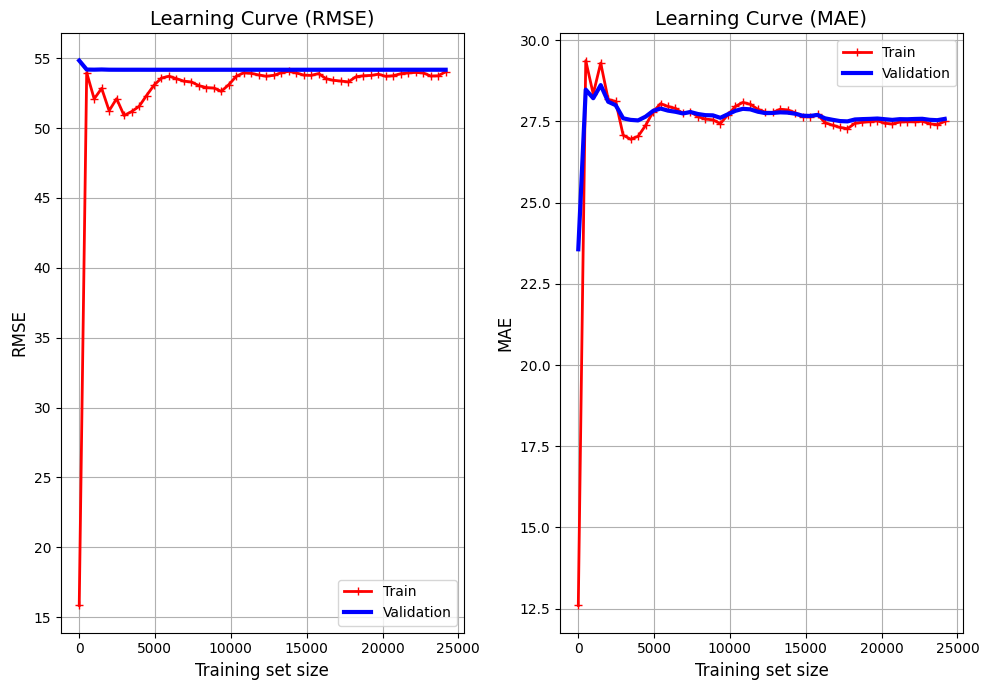

In [10]:
plot_learning_curves(dummy, X_train_scaled, y_train, X_valid_scaled, y_valid, n_points=50)

From these results, we can clearly see that the naive model is underfitting the data. The RMSE and MAE do appear to converge, but to large values of RMSE and MAE. 

Below we plot the actual and predicted values of the naive model along with the MSE and MAE of our naive model on the test set. 


Test MSE: 2993.0309
Test MAE: 27.7149


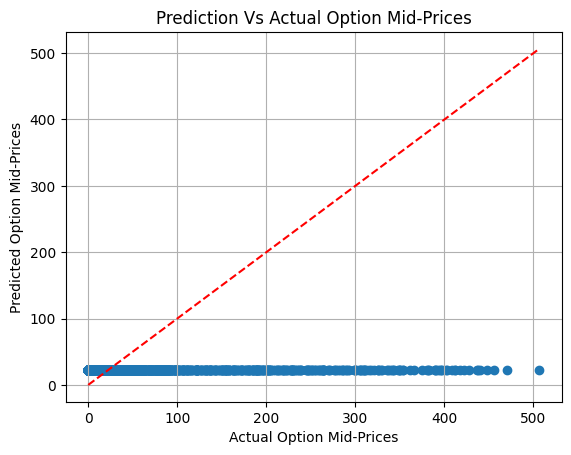

In [11]:
y_pred_test_dummy = dummy.predict(X_test_scaled)

mse_dummy = mean_squared_error(y_test, y_pred_test_dummy)
mae_dummy = mean_absolute_error(y_test, y_pred_test_dummy)

print(f"\nTest MSE: {mse_dummy:.4f}")
print(f"Test MAE: {mae_dummy:.4f}")

plt.scatter(y_test, y_pred_test_dummy)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Option Mid-Prices")
plt.ylabel("Predicted Option Mid-Prices")
plt.title("Prediction Vs Actual Option Mid-Prices")
plt.grid(True)
plt.show()

The predicted prices are constant throughout as expected. Clearly this does a poor job of estimating our option prices. We can further see that the test MSE and MAE are extremely high. 

Below we plot the distribution of the model residuals.

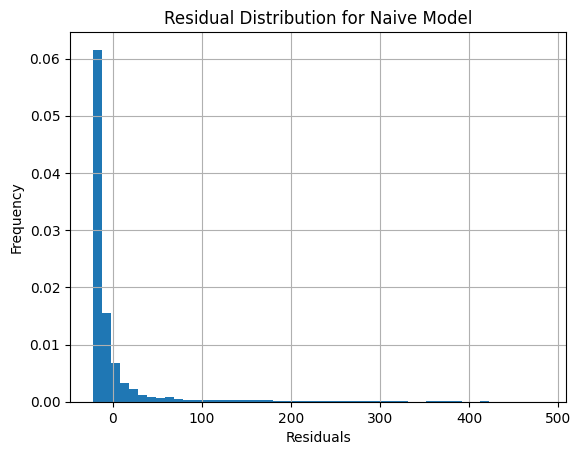

In [12]:
residuals_dummy = y_test - y_pred_test_dummy
plt.hist(residuals_dummy, bins=50, density=True)
plt.title("Residual Distribution for Naive Model")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

We can see that the residuals have a positive skew, meaning that the majority of the estimates of the naive model are below the true option prices.

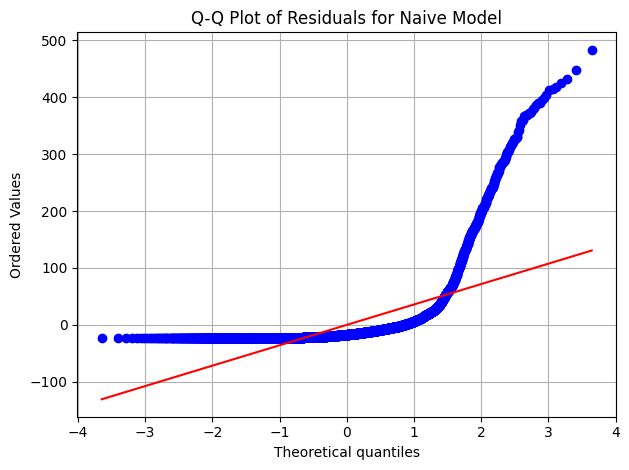

In [13]:
stats.probplot(residuals_dummy, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals for Naive Model")
plt.grid(True)
plt.tight_layout()
plt.show()

From the QQ-plot above we can see that the residuals are clearly not normally distributed. As we saw in the histogram there is a positive skew.

## Support Vector Regression

We will run a quick pilot study to narrow our search down to one kernel. Ideally would would explore each of them more, but given the complexity of our data structure we are confident that the RBF kernel will be most effective. This is most commonly used when pricing options with SVR, as seen in Wang and Zhang (2010) and Andreou et Alias (2009). We will test each kernel with default hyperparameters to ensure that the RBF kernel is outperforming other kernels, but will not examine this further.

In [14]:
kernels = ['linear', 'poly', 'sigmoid', 'rbf',]
results = {}

for kernel in kernels:
    print(f"\nSVR with {kernel} Kernel")

    model = SVR(kernel=kernel, C=1.0, epsilon=0.1)

    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_valid_scaled)

    mse = mean_squared_error(y_valid, y_pred)

    mae = mean_absolute_error(y_valid, y_pred)

    results[kernel] = {'MSE': mse, 'MAE': mae}
    print(f"Validation MSE: {mse:.4f}")
    print(f"Validation MAE: {mae:.4f}")


SVR with linear Kernel
Validation MSE: 862.4484
Validation MAE: 10.1338

SVR with poly Kernel
Validation MSE: 485.2563
Validation MAE: 9.0620

SVR with sigmoid Kernel
Validation MSE: 79090.0403
Validation MAE: 134.4501

SVR with rbf Kernel
Validation MSE: 349.9289
Validation MAE: 5.4849


Based on these results, we can see that our SVR performed best using the RBF kernel, as we expected. The difference is significant by all metrics.

Now that we have analyzed our naive RBF kernel model we will move on to tuning the hyperparameters to see if it significantly improves the accuracy. For hyperparameter tuning we are going to utilize the random search method. We are working with 3 parameters that can take on a continuous range of values. To briefly summarize each of the parameters

- $C$ controls the degree to which margin violations are penalized
- $\varepsilon$ controls the margin of error that we ignore
- $\gamma$ controls how 'local' the decision boundary is

Each of three parameters can take the value of any postive real number. Below we test a range of these values with the RBF kernel. 

In [15]:
model_rbf = SVR(kernel='rbf')

param_distributions = {
    'C': loguniform(1e-1, 1e3),       
    'gamma': loguniform(1e-4, 1),      
    'epsilon': uniform(0.01, 0.3)    
}

search = RandomizedSearchCV(
    model_rbf,
    param_distributions=param_distributions,
    n_iter=50,             
    scoring='neg_mean_squared_error',
    cv=3,                    
    n_jobs=-1,              
    random_state=42
)

search.fit(X_train_scaled, y_train)

print("Best Parameters Found:")
print(search.best_params_)

print("\nBest CV MSE:", -search.best_score_)

y_pred = search.predict(X_valid_scaled)
mse = mean_squared_error(y_valid, y_pred)
mae = mean_absolute_error(y_valid, y_pred)

print(f"\nValidation MSE: {mse:.4f}")
print(f"Validation MAE: {mae:.4f}")

Best Parameters Found:
{'C': np.float64(624.5139574743067), 'epsilon': np.float64(0.2996896099223678), 'gamma': np.float64(0.17123375973163968)}

Best CV MSE: 4.155204154630549

Validation MSE: 1.7905
Validation MAE: 0.2743


As we can see the high $C$ value, this model penalizes errors severely. Still it selects a relatively high epsilon of 0.3, so it accepts a small margin of error. The model selects a moderate gamma, not making decisions boundary too local, and allowing the model to generalize slightly more. 

Below we call the function to generate learning curves for our SVR regressor with the RBF kernel and optimized hyperparameters. We can see already from the result above that this model performs well on the validation sets, with MSE of about 1.8 and MAE error of less than 0.3. Recall from our naive model that the MSE was nearly 3000, so this result is encouraging. Note that the validation data shown in the plots below is from the mean across our 3 cross-validation folds in the training data, not the validation dataset that we seperated at the beginning. The validation set predictions are meant to give us some idea about model performance at this stage.

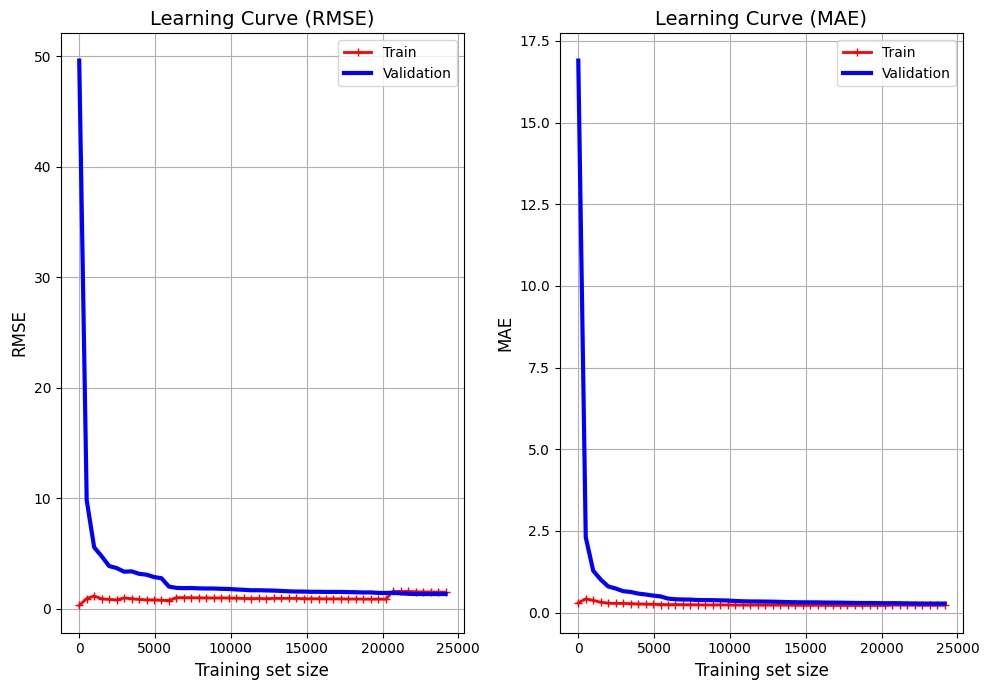

In [16]:
best_model_plot = SVR(kernel='rbf', **search.best_params_)

plot_learning_curves(best_model_plot, X_train_scaled, y_train, X_valid_scaled, y_valid)

Now we can determine the results of running this support vector regression on our test data. 

We can see that the errors decrease rapidly as training size increases, with a sharp elbow at aroun 1000 data points. The validation and training sets RMSE and MAE converge to very lower values, with minimal seperation between the two lines. This indicates that our model is neither overfitting or underfitting. 

In [17]:
best_model = search
y_pred_test = best_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"\nTest MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")


Test MSE: 3.0602
Test MAE: 0.2814


The results from our test data show a MSE of about 3, which is a strong result. We saw that our naive data had a MSE of nearly 3000, so clearly the support vector regressor with RBF kernel is outperformming that. The MAE is only about 0.28, which suggests that the results from our MSE are being impacted heavily by outliers. We will now look at how the residuals from the support vector regressor behave.

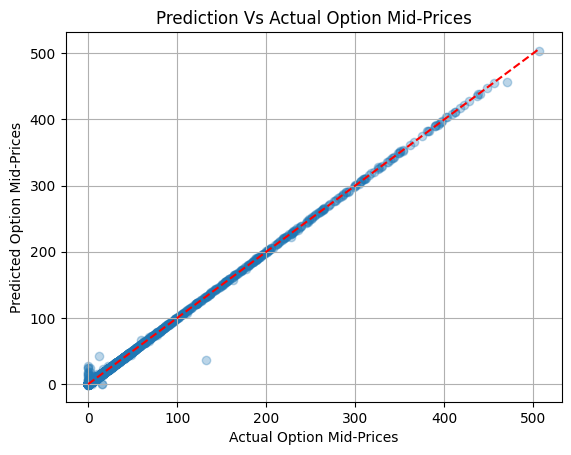

In [18]:
plt.scatter(y_test, y_pred_test, alpha = 0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Option Mid-Prices")
plt.ylabel("Predicted Option Mid-Prices")
plt.title("Prediction Vs Actual Option Mid-Prices")
plt.grid(True)
plt.show()

From this plot of the predicted vs actual option prices we can see that the every point is close to the actual values. There appears to be some more variance in results closer to zero, but for higher prices the results appear to perform consistently very well. There are a few outliers, most notably at an actual price of around 130, which could be having a large impact on our MSE, as the actual and predicted price appear to have a difference of about 100. Most of the other errors seem to be clustered very close to the actual price of 0.

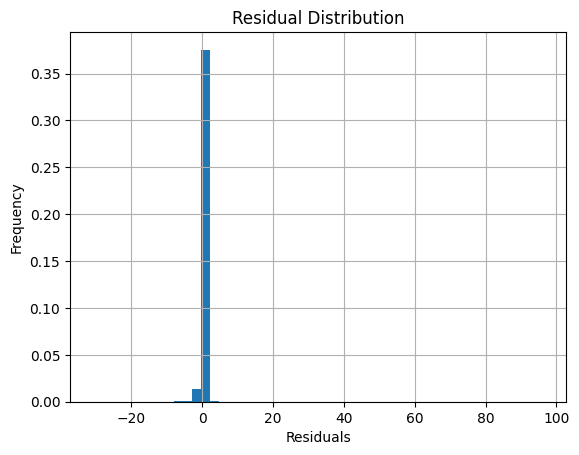

In [19]:
residuals = y_test - y_pred_test
plt.hist(residuals, bins=50, density=True)
plt.title("Residual Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

From this plot of our residuals, we can see that the vast majority are clustered around zero. This is a good sign, and tells use that our support vector regression likely does not have a positive or negative skew.

Below we also plot a QQ-plot. Note that there is no assumption of normality of error terms in support vector regression, like there is in linear regression, so we dont actually expect the errors to be normally distributed. We are only doing this to better understand the distribution of the residuals.

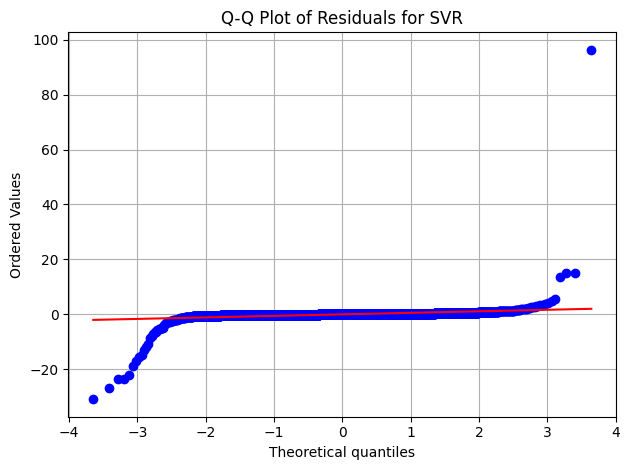

In [20]:
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals for SVR")
plt.grid(True)
plt.tight_layout()
plt.show()

We can see that there are significantly heavier postive and negative tails than you would typically see in a normal distribution. This makes sense, because the model is indifferent to small residuals that fall inside the band created by the hyperparameter. In fact the MAE was about 0.28, which was very close to the value of 
m which was about 0.3. This means that residuals can spread out freely near the edge of this boundary, making the distribution have significantly heavier tails than a normal distribution. This behavior is expected, but is a downside of the model. The width of epsilon could become more significant of a factor for options that have a low prices point. In fact we saw that to some degree when we plotted the actual and predicted values against one another. At lower price points there was a more obvious spread, which suggests that this band was having a noticable impact on the predicted price. We need to be very careful when using it to price extremely low price options, because in those price ranges the band created by epsilon is much more noticable.

Overall this model is very promising, but has could have issues modeling options in low price ranges. Still it performs very constitently throughout the training, validation and test sets, and generates a low MSE and MAE for the test set, which indicates it is able to price these options effectively. There was only 1 extreme outlier in our results, which suggests that it performs consistently. The MSE was boosted by some outliers, but with MAE was low, around 0.3.

## References

Wang, J., & Zhang, J. (2010). Stock trend prediction based on a new status box method. Expert Systems with Applications, 37(8), 5640–5649. https://doi.org/10.1016/j.eswa.2010.02.094

Andreou, P. C., Charalambous, C., & Martzoukos, S. H. (2010). European option pricing by using the support vector regression approach. In Artificial Intelligence Applications and Innovations (pp. 247–256). Springer. https://doi.org/10.1007/978-3-642-16239-8_26

----

# Wooseok's Model

In [15]:
import pandas as pd 
import numpy as np 
import os
import requests
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## 1

Option prices are governed by highly non linear functions of multiple inputs, so I wanted to use the model that can handle these which was Random forests(RF). 
Random Forests build an ensemble of decision trees, each of which can split on feature thresholds in a nonlinear way and by averaging such trees, we can approximate the complex surface that maps the variables to the mid-price that we want.

The features of option pricing tends to interact each other such as the greeks and the implied volatility are correlated. When using the Random Forest, in the process of splitting trees, for example, first split on strike, then implied volatility and so on, the model can learn the pairwise interactions without manual feature setting, which seems to be a nice fit.

Also, RF do not require rigid scaling or normalization of the data so, it is quite simple when preprocessing data. 

The built in function of feature importance can also help us analyze which factors or which combination of factors explain the option pricing the most which can lead to future feature engineering. 

first, as a rule of thumb, I'll start with setting the parameters as following.

In [16]:
rf = RandomForestRegressor(
    n_estimators = 100,
    max_depth = None, 
    min_samples_leaf = 5,
    max_features = "sqrt",
    random_state = 42,
    n_jobs= -1
)

rf.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=5, n_jobs=-1,
                      random_state=42)

## 2

To start with, I set the baseline as a common trivial regression, predicting the training set mean. 
The reason why I used the mean of training set is because since we are comparing with a model learning with the "train set", we need to make sure there is no leak of information from the validation or test set. 

then tried to simply compare the MAE, RMSE with the validaiton set.

The result shows a lot more smaller values on both, which we can at least know that the RF regressor is extracting some real structure beyond just average prices.

In [18]:
#baseline

base_pred = np.full_like(y_valid, fill_value = np.mean(y_train))
mae_base = mean_absolute_error(y_valid, base_pred)
rmse_base = np.sqrt(mean_squared_error(y_valid, base_pred))

print(f"the baseline mae : {mae_base:.4f}")
print(f"the baseline rmse : {rmse_base:.4f}")

y_valid_pred = rf.predict(X_valid)

mae_valid = mean_absolute_error(y_valid, y_valid_pred)
rmse_valid = np.sqrt(mean_squared_error(y_valid, y_valid_pred))

print(f"the valid set mae:{mae_valid:.4f}")
print(f"the valid set rmse:{rmse_valid:.4f}")

the baseline mae : 27.5750
the baseline rmse : 54.1754
the valid set mae:1.7722
the valid set rmse:5.6103


## 3

this time, I tried to fix other hyperparameters except max depth to see which shows better performance.

I will be doing the sequential tuning since if we use the GridSearchCV, cannot guarantee how much computing time it will take. 

I started with the max_depth since I thought it can give me the sense at which point of the max_depth that the model converts from underfitting to overfitting.

As you can see the result below, the loss seems to move meaningfully between depth= 15, 20 and furthermore is pretty much same. So I will be trying to test depth (15,) 20 for further hyperparameter tuning. 

In [19]:
for depth in [5, 10, 15, 20]:
    rf = RandomForestRegressor(max_depth=depth, random_state=42)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    valid_pred = rf.predict(X_valid)

    train_loss = mean_squared_error(y_train, train_pred)    
    valid_loss = mean_squared_error(y_valid, valid_pred)    

    print(f"depth={depth}, train_loss={train_loss:.4f}, valid_loss={valid_loss:.4f}")

depth=5, train_loss=131.4372, valid_loss=126.2542
depth=10, train_loss=4.6183, valid_loss=7.3606
depth=15, train_loss=0.9190, valid_loss=3.6485
depth=20, train_loss=0.8485, valid_loss=3.5252


In [20]:
for depth in [25, None]:
    rf = RandomForestRegressor(max_depth=depth, random_state=42)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    valid_pred = rf.predict(X_valid)

    train_loss = mean_squared_error(y_train, train_pred)    
    valid_loss = mean_squared_error(y_valid, valid_pred)    

    print(f"depth={depth}, train_loss={train_loss:.4f}, valid_loss={valid_loss:.4f}")

depth=25, train_loss=0.8256, valid_loss=3.5268
depth=None, train_loss=0.8395, valid_loss=3.5491


## 3 - 1

I'll fix the max_depth = 20 and try the loop for n_estimators [50, 100, 150] and min_samples_leaf [5, 10] and see the best hyperparameters.

Looking at the result below, we can see that best hyperparameters with our set would be, n_estimators : 100, min_samples_leaf : 5, max_depth : 20.

In [21]:
results = []

n_list = [50, 100, 150]
leaf_list = [5, 10]

for n in n_list:
    for leaf in leaf_list:
        rf = RandomForestRegressor(
            n_estimators = n,
            max_depth = 20,
            min_samples_leaf = leaf,
            max_features = "sqrt",
            random_state = 42,
            n_jobs=-1
        )
        rf.fit(X_train, y_train)
        y_val_pred = rf.predict(X_valid)
        val_mse = mean_squared_error(y_valid, y_val_pred)
        results.append({
            "n_est": n,
            "min_samples_leaf":leaf,
            "val_mse": val_mse
        })

df_results = pd.DataFrame(results)
print(df_results)

   n_est  min_samples_leaf    val_mse
0     50                 5  32.602595
1     50                10  50.220698
2    100                 5  31.815225
3    100                10  46.011416
4    150                 5  32.202335
5    150                10  44.659419


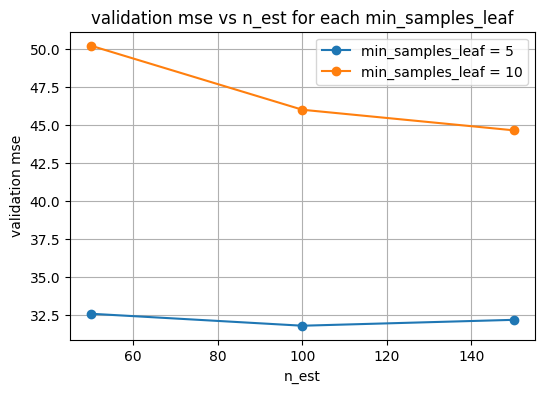

In [22]:
plt.figure(figsize=(6,4))

for leaf in leaf_list:
    subset = df_results[df_results["min_samples_leaf"] == leaf]
    subset = subset.sort_values("n_est")
    plt.plot(
        subset["n_est"],
        subset["val_mse"],
        marker="o",
        label = f"min_samples_leaf = {leaf}"
    )

plt.xlabel("n_est")
plt.ylabel("validation mse")
plt.title("validation mse vs n_est for each min_samples_leaf")
plt.grid(True)
plt.legend()
plt.show()

## 4

with the best hyperparameters we got, I updated the RF Regressor again.
since we finished the tuning for hyper parameters, we trained it with the train+valid data.

Then I computed the mae, rmse for the test data and it was almost the same as the result of valid data with the previous regressor. 
The scatter plot with the predict and the test set quite shows a linear relation which seems nice. 

In [23]:
final_rf = RandomForestRegressor(
    n_estimators=100,
    max_depth = 20,
    min_samples_leaf = 5,
    max_features = "sqrt",
    random_state=42,
    n_jobs=-1
)

X_train_full = pd.concat([X_train, X_valid], axis=0)
y_train_full = pd.concat([y_train, y_valid], axis=0)

final_rf.fit(X_train_full, y_train_full)

RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=5,
                      n_jobs=-1, random_state=42)

1.6659883574156957
5.7158874607488475


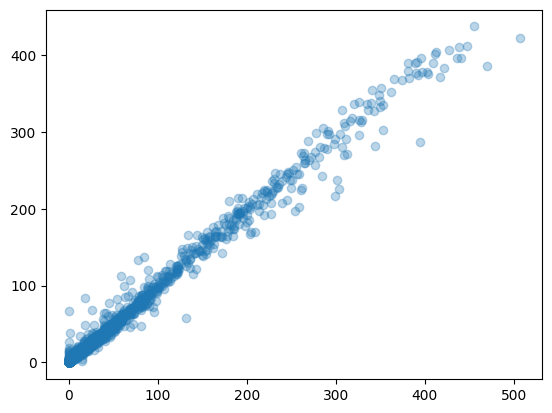

In [25]:
y_test_pred = final_rf.predict(X_test)

mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
# r2_test = r2_score(y_test, y_test_pred)

print(mae_test)
print(rmse_test)
# print(r2_test)

plt.scatter(y_test, y_test_pred, alpha=0.3)

## 4 - 1

I checked the feature importance to see which factors is the most influential.

It looks like the Close, Strike, Delta are the first three factors, with high feature importance.

close: 0.2866
strike: 0.2349
delta: 0.2216
gamma: 0.0840
implied_volatility: 0.0538
theta: 0.0527
tte: 0.0385
vega: 0.0280


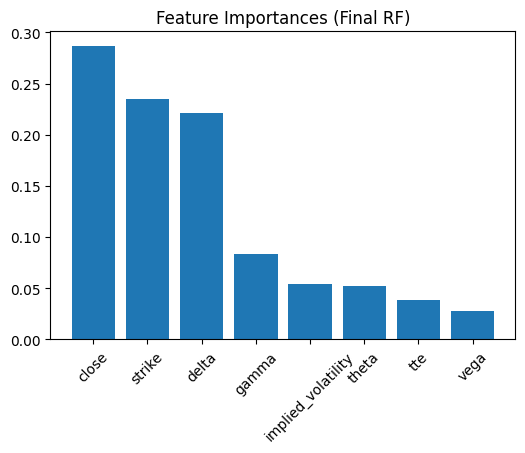

In [26]:
importances_final = final_rf.feature_importances_
feature_names = X_train.columns  
indices = np.argsort(importances_final)[::-1]
for idx in indices:
    print(f"{feature_names[idx]}: {importances_final[idx]:.4f}")


plt.figure(figsize=(6, 4))
plt.bar(range(len(importances_final)), importances_final[indices], align="center")
plt.xticks(range(len(importances_final)), [feature_names[i] for i in indices], rotation=45)
plt.title("Feature Importances (Final RF)")
plt.show()

## 4 - 2
Here, based on the importance feature above, I did the plot for the residuals according to each main factors. 

/var/folders/pl/lb47l1xs3j10tbxpzsz3ycpr0000gn/T/ipykernel_62178/2013953939.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
/var/folders/pl/lb47l1xs3j10tbxpzsz3ycpr0000gn/T/ipykernel_62178/2013953939.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()
/var/folders/pl/lb47l1xs3j10tbxpzsz3ycpr0000gn/T/ipykernel_62178/2013953939.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend()


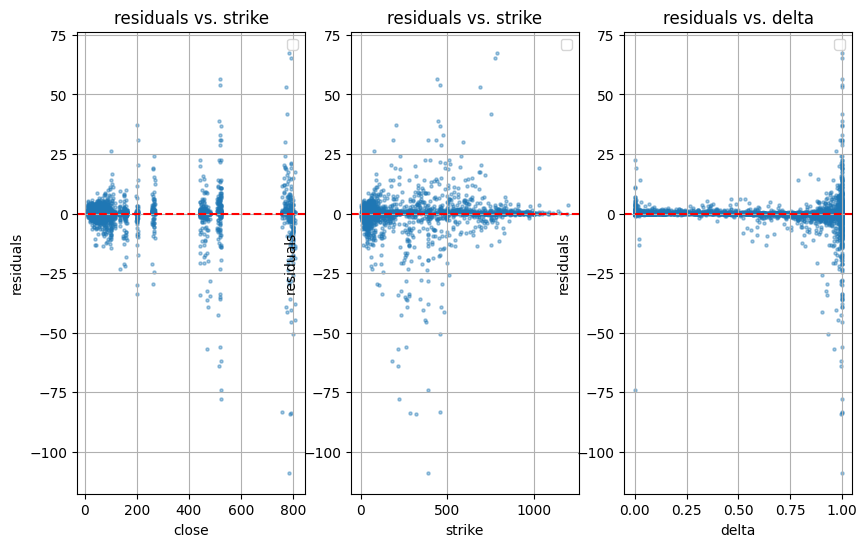

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(10, 6))

residuals_test = y_test_pred - y_test
# ax1.hist(residuals_test, bins=50)
# ax1.set_xlabel("prediction error")
# ax1.set_ylabel("frequency")
# ax1.grid(True)
# ax1.legend()

ax1.scatter(X_test["close"], residuals_test, s=5, alpha=0.4)
ax1.axhline(0, color='red', linestyle='--')
ax1.set_title("residuals vs. strike")
ax1.set_xlabel("close")
ax1.set_ylabel("residuals")
ax1.grid(True)
ax1.legend()

ax2.scatter(X_test["strike"], residuals_test, s=5, alpha=0.4)
ax2.axhline(0, color='red', linestyle='--')
ax2.set_title("residuals vs. strike")
ax2.set_xlabel("strike")
ax2.set_ylabel("residuals")
ax2.grid(True)
ax2.legend()

ax3.scatter(X_test["delta"], residuals_test, s=5, alpha=0.4)
ax3.axhline(0, color='red', linestyle='--')
ax3.set_title("residuals vs. delta")
ax3.set_xlabel("delta")
ax3.set_ylabel("residuals")
ax3.grid(True)
ax3.legend()

plt.show()

For the close plot, we can know that we are missing some range of close call prices and the residuals tend to have smaller variance among the smaller close prices which would be because the majority of data is densed there so it is trained well.

For the strike plot, it shows quite steady and dense scatter among strike price of 100~200 and 800~1000. The residuals among strike price of 200~500 shows some negative values whereas it shows positive residuals for the positive strikes. For the former the price tends to be underestimated, the latter overestimated. 

For the delta plot, the residuals seem to pike as it gets bigger and there is a steady residuals around zero among 0.1 to 0.5. For this, we can think of some reasons. It might be because of the trading volume is more concentratd around 0.3 to 0.6. With relatively small data, RF tends to overfit the sparse, noisy examples which produces higher variance. Also, at the tails, the bid ask spreads can be large so since we are using the mid price for our y data, mid prices can be jumped and the plot shows high variance. 

## 4 - 3
learning curves.
As the result below, the learning curve shows some significant elbow since around train data of 5000 to 7500. 
The mse of train and validation tends to converge each other but still the value is large. 
we can think that with a larger train data set, it prevents some overfitting, but also it can be interpreted as still got some overfitting issue with the data around 19000. 
Therefore, we can try with a bigger dataset or try to optimize the hyperparameters more tightly to get a better regressor. 

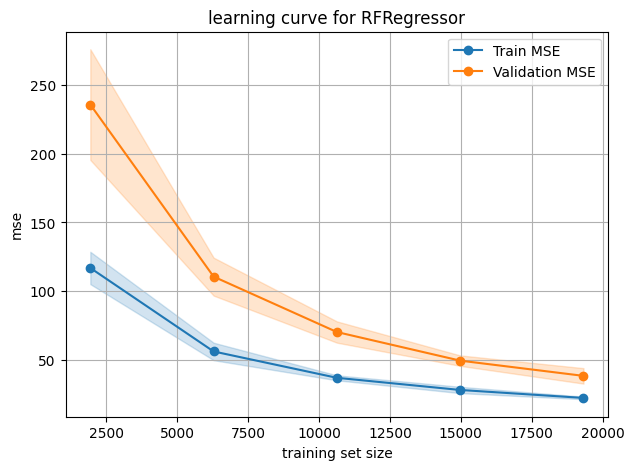

In [28]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold

cv = KFold(n_splits = 5, shuffle=True, random_state=42)

train_sizes, train_scores, valid_scores = learning_curve(
    estimator = final_rf,
    X = X_train,
    y = y_train,
    train_sizes = np.linspace(0.1, 1.0, 5),
    cv = cv,
    scoring= "neg_mean_squared_error",
    n_jobs=-1,
    shuffle=True,
    random_state = 42
)

train_mse_mean = -train_scores.mean(axis=1)
train_mse_std = train_scores.std(axis=1)
valid_mse_mean = -valid_scores.mean(axis=1)
valid_mse_std = valid_scores.std(axis=1)

plt.figure(figsize=(7,5))
plt.fill_between(
    train_sizes,
    train_mse_mean - train_mse_std,
    train_mse_mean + train_mse_std,
    alpha=0.2,
    color="C0"
)
plt.fill_between(
    train_sizes,
    valid_mse_mean - valid_mse_std,
    valid_mse_mean + valid_mse_std,
    alpha=0.2,
    color="C1"
)

plt.plot(train_sizes, train_mse_mean, "o-", color="C0", label="Train MSE")
plt.plot(train_sizes, valid_mse_mean, "o-", color="C1", label="Validation MSE")
plt.xlabel("training set size")
plt.ylabel("mse")
plt.title("learning curve for RFRegressor")
plt.legend(loc="best")
plt.grid(True)
plt.show()

below, I tried to make a more rigid hyperparameter test with,
any integer from 50 to 200,
various max depth,
any integer from 5 to 30,
varying max features,
and trying 30 random combinations while RandomizedSearchCV.

The best hyperparameter combination differed as final_rf so I tried to apply it to see the different result but the tendency seemed similar while there was a quite reduction in the rmse of the test, validation both. 

In [31]:

param_dist = {
    "n_estimators":    stats.randint(50, 201),    # any integer from 50 to 200
    "max_depth":       [8, 10, 12, 15, 20, None],
    "min_samples_leaf": stats.randint(5, 31),     # any integer from 5 to 30
    "max_features":    ["sqrt", "log2", 2, 3]  # either of these strings or ints
}

rand_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=30,               # to try 30 random combinations
    scoring="neg_mean_squared_error",
    cv=cv,
    random_state=42,
    n_jobs=-1
)

rand_search.fit(X_train, y_train)
print("Best Randomized params:", rand_search.best_params_)
best_rf = rand_search.best_estimator_

Best Randomized params: {'max_depth': 10, 'max_features': 3, 'min_samples_leaf': 6, 'n_estimators': 63}


In [32]:
final_rf_2 = RandomForestRegressor(
    n_estimators=63,
    max_depth = 10,
    min_samples_leaf = 6,
    max_features = 3,
    random_state=42,
    n_jobs=-1
)

X_train_full = pd.concat([X_train, X_valid], axis=0)
y_train_full = pd.concat([y_train, y_valid], axis=0)

final_rf_2.fit(X_train_full, y_train_full)

RandomForestRegressor(max_depth=10, max_features=3, min_samples_leaf=6,
                      n_estimators=63, n_jobs=-1, random_state=42)

2.045365997864838
5.670575070815195


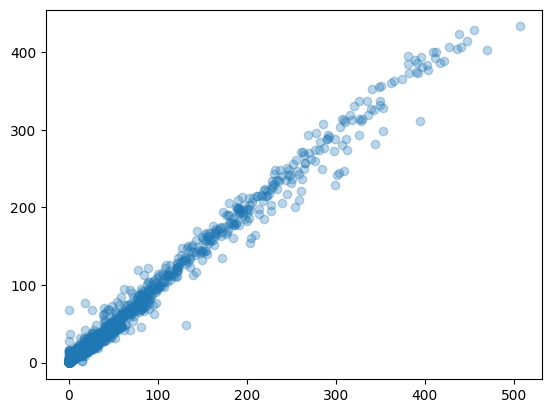

In [33]:
y_test_pred_2 = final_rf_2.predict(X_test)

mae_test = mean_absolute_error(y_test, y_test_pred_2)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred_2))
# r2_test = r2_score(y_test, y_test_pred)

print(mae_test)
print(rmse_test)
# print(r2_test)

plt.scatter(y_test, y_test_pred_2, alpha=0.3)

/var/folders/pl/lb47l1xs3j10tbxpzsz3ycpr0000gn/T/ipykernel_62178/1208410254.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
/var/folders/pl/lb47l1xs3j10tbxpzsz3ycpr0000gn/T/ipykernel_62178/1208410254.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()
/var/folders/pl/lb47l1xs3j10tbxpzsz3ycpr0000gn/T/ipykernel_62178/1208410254.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend()


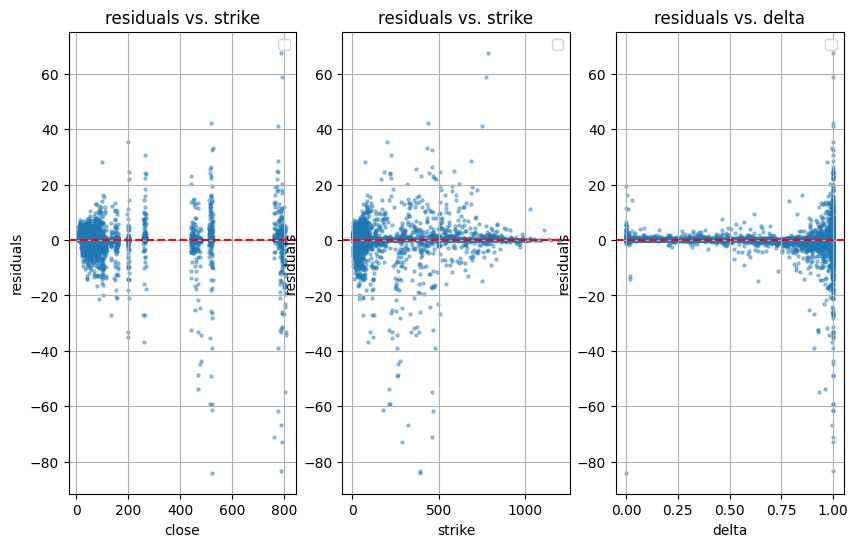

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(10, 6))

residuals_test2 = y_test_pred_2 - y_test
# ax1.hist(residuals_test, bins=50)
# ax1.set_xlabel("prediction error")
# ax1.set_ylabel("frequency")
# ax1.grid(True)
# ax1.legend()

ax1.scatter(X_test["close"], residuals_test2, s=5, alpha=0.4)
ax1.axhline(0, color='red', linestyle='--')
ax1.set_title("residuals vs. strike")
ax1.set_xlabel("close")
ax1.set_ylabel("residuals")
ax1.grid(True)
ax1.legend()

ax2.scatter(X_test["strike"], residuals_test2, s=5, alpha=0.4)
ax2.axhline(0, color='red', linestyle='--')
ax2.set_title("residuals vs. strike")
ax2.set_xlabel("strike")
ax2.set_ylabel("residuals")
ax2.grid(True)
ax2.legend()

ax3.scatter(X_test["delta"], residuals_test2, s=5, alpha=0.4)
ax3.axhline(0, color='red', linestyle='--')
ax3.set_title("residuals vs. delta")
ax3.set_xlabel("delta")
ax3.set_ylabel("residuals")
ax3.grid(True)
ax3.legend()

plt.show()

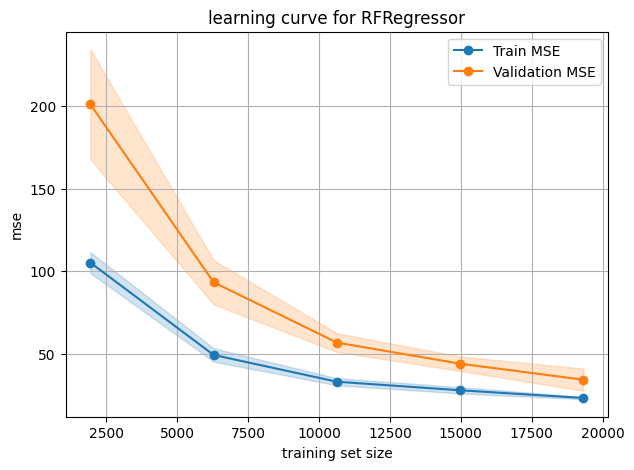

In [35]:
cv = KFold(n_splits = 5, shuffle=True, random_state=42)

train_sizes, train_scores, valid_scores = learning_curve(
    estimator = final_rf_2,
    X = X_train,
    y = y_train,
    train_sizes = np.linspace(0.1, 1.0, 5),
    cv = cv,
    scoring= "neg_mean_squared_error",
    n_jobs=-1,
    shuffle=True,
    random_state = 42
)

train_mse_mean = -train_scores.mean(axis=1)
train_mse_std = train_scores.std(axis=1)
valid_mse_mean = -valid_scores.mean(axis=1)
valid_mse_std = valid_scores.std(axis=1)

plt.figure(figsize=(7,5))
plt.fill_between(
    train_sizes,
    train_mse_mean - train_mse_std,
    train_mse_mean + train_mse_std,
    alpha=0.2,
    color="C0"
)
plt.fill_between(
    train_sizes,
    valid_mse_mean - valid_mse_std,
    valid_mse_mean + valid_mse_std,
    alpha=0.2,
    color="C1"
)

plt.plot(train_sizes, train_mse_mean, "o-", color="C0", label="Train MSE")
plt.plot(train_sizes, valid_mse_mean, "o-", color="C1", label="Validation MSE")
plt.xlabel("training set size")
plt.ylabel("mse")
plt.title("learning curve for RFRegressor")
plt.legend(loc="best")
plt.grid(True)
plt.show()

----

# Steve's Model

## Baseline Model

For my model's architecture, I decided to use 4 hidden layers with 50 neurons each with 'ReLU' activation, 'he_normal' initializer, 'Nadam' optimizer, early stopping with a patience of 10, and "MSE" as the primary loss metric, and "MAE" as the secondary loss metric. The choice to use 4 hidden layers with 50 neurons was somewhat arbitrary and not backed by any theoretical justification other than the expectation of it being able to accurately capture any non-linear relationships occuring with options pricing. The output layer would remain the default linear activation function with one neuron as we are expecting a single value, the mid price. I also chose the "ReLU" activation function for each neuron with "he_normal" initializer to better model the non-linear relationship and avoid vanishing gradients during training. Additionally, "ReLU" works well because it encourages positive only outputs, which matches with the intrinsic value of an option is defined as: $V = \text{max}(S_T - K, 0)$. The 'Nadam' optimizer was chosen here as its learning rate is adaptable, allowing it to converge faster and smoother for non-linear functions compared to other optimizers. Early stopping was added as a form of regularization to prevent unnecessary training once the model stops improving on the validation set. Given the time required to train the model, early stopping is an effective way to reduce training time while also helping to avoid overfitting. Since the objective of this project is to predict option prices, Mean Squared Error (MSE) and Mean Absolute Error (MAE) are appropriate evaluation metrics. MSE penalizes larger errors more heavily, making it useful for identifying significant prediction deviations, while MAE provides a more interpretable measure of the average prediction error.

In [15]:
def define_features(df):
    df['expiration'] = pd.to_datetime(df['expiration'])
    df['quote_date'] = pd.to_datetime(df['quote_date'])
    df['tte'] = (df['expiration'] - df['quote_date']).dt.days / 252
    X = df[['close', 'strike', 'delta', 'gamma',
            'vega', 'theta', 'implied_volatility', 'tte']]
    y = df['mid_price']
    return X, y

def get_features():
    X_feats = []
    y_feats = []
    for df in [train, valid, test]:
        df = df.copy()
        X, y = define_features(df)
        X_feats.append(X)
        y_feats.append(y)
    return X_feats, y_feats

X_feats, y_feats = get_features()
X_train, X_valid, X_test = X_feats
y_train, y_valid, y_test = y_feats

In [16]:
def scale_data(train, val, test):
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train)
    valid_scaled = scaler.transform(val)
    test_scaled = scaler.transform(test)
    return train_scaled, valid_scaled, test_scaled

def reset_session(seed=42):
    tf.keras.backend.clear_session()
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
def build_model(input_shape):
    reset_session()
    model = tf.keras.Sequential([
        tf.keras.Input(shape = (input_shape,)),
        tf.keras.layers.Dense(50, activation = "relu", kernel_initializer = "he_normal"),
        tf.keras.layers.Dense(50, activation = "relu", kernel_initializer = "he_normal"),
        tf.keras.layers.Dense(50, activation = "relu", kernel_initializer = "he_normal"),
        tf.keras.layers.Dense(50, activation = "relu", kernel_initializer = "he_normal"),
        tf.keras.layers.Dense(1)
    ])
    
    model.compile(
        optimizer = "nadam",
        loss = "mse",
        metrics = ['mae']
    )
    return model

X_train_scaled, X_valid_scaled, X_test_scaled = scale_data(X_train, X_valid, X_test)

early_stop = EarlyStopping(
    monitor = "val_loss",
    patience = 10,
    mode = "min",
    restore_best_weights = True
)

In [17]:
model = build_model(X_train_scaled.shape[1])

start = time.time()
history_baseline = model.fit(X_train_scaled, y_train,
             validation_data = (X_valid_scaled, y_valid),
             epochs = 50, verbose = 1, callbacks=[early_stop])
end = time.time()
baseline_time = end-start

mse_val, mae_val = model.evaluate(X_valid_scaled,
                                        y_valid, verbose = 0)
test_loss, test_mae = model.evaluate(X_test_scaled,
                                        y_test, verbose = 0)

print("\Baseline Model:")
print(f"Validation MSE: {mse_val}")
print(f"Validation MAE: {mae_val}")

print(f"\nTest MSE: {test_loss}")
print(f"Test MAE: {test_mae}")

Epoch 1/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1161.7683 - mae: 11.8512 - val_loss: 25.2202 - val_mae: 2.8753
Epoch 2/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 18.8297 - mae: 2.4889 - val_loss: 13.0825 - val_mae: 2.1954
Epoch 3/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.4716 - mae: 1.7091 - val_loss: 31.9374 - val_mae: 3.1973
Epoch 4/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.4068 - mae: 1.4343 - val_loss: 44.0370 - val_mae: 3.6843
Epoch 5/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.7642 - mae: 1.3302 - val_loss: 27.2706 - val_mae: 2.9078
Epoch 6/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.8000 - mae: 1.2063 - val_loss: 23.2722 - val_mae: 2.5701
Epoch 7/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.0971 - mae: 1.0974 - val_loss: 19.9967 - val_mae: 2.3136
Epoch 8/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.7856 - mae: 1.0373 - val_loss: 14.7044 - val_mae: 1.9529
Epoch 9/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 

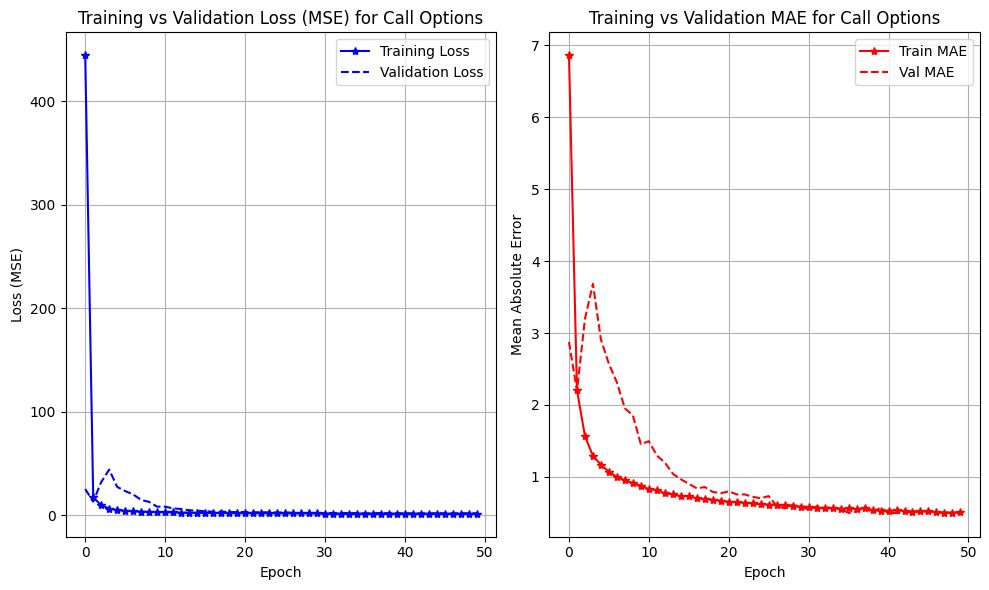

In [18]:
def plot_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 6))

    ax1.plot(history.epoch, history.history["loss"], '*-', label="Training Loss", color='b')
    ax1.plot(history.epoch, history.history["val_loss"], '--', label="Validation Loss", color='b')
    ax1.set_title("Training vs Validation Loss (MSE) for Call Options")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss (MSE)")
    ax1.grid(True)
    ax1.legend()
    
    ax2.plot(history.epoch, history.history["mae"], '*-', label="Train MAE", color='r')
    ax2.plot(history.epoch, history.history["val_mae"], '--', label="Val MAE", color='r')
    ax2.set_title("Training vs Validation MAE for Call Options")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Mean Absolute Error")
    ax2.grid(True)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_learning_curves(history_baseline)

As we can see from the learning curves above, the training loss and the validation loss converge closely, suggesting that the model is learning effectively without overfitting. We can also confirm this by looking at the training and validation MAE which also converges.

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


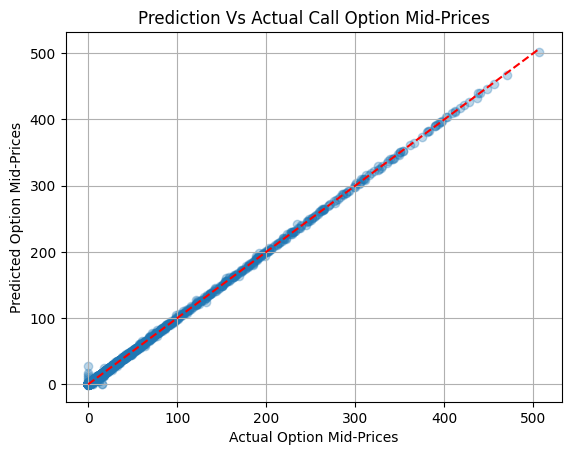

In [19]:
def get_prediction_plot(model, X_test_s, y_test):
    y_pred = model.predict(X_test_s)
    
    residuals = y_test - y_pred.flatten()
    plt.scatter(y_test, y_pred, marker = 'o', alpha = 0.3)
    plt.plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Option Mid-Prices")
    plt.ylabel("Predicted Option Mid-Prices")
    plt.title(f"Prediction Vs Actual Call Option Mid-Prices")
    plt.grid(True)
    plt.show()
    return residuals

residuals = get_prediction_plot(model, X_test_scaled, 
                    y_test)

This plot allows us to visualize how well the model predicted the mid-price of the option, with a perfectly diagonal line indicating all the predictions were completely accurate. The model does seem to follow this diagonal line but there is a noticeable deviation around 0 where predictions seem to be less accurate.

In [20]:
residuals.name = "residuals"
display(residuals.to_frame().describe())

,residuals
count,5178.000000
mean,-0.037208
std,1.000607
min,-28.144381
25%,-0.272286
50%,-0.057737
75%,0.134848
max,15.067522


The summary statistics of the residuals show that the model’s average error is close to zero, indicating that, on average, the predicted option prices closely match the actual values. The standard deviation of approximately 1 suggests that most prediction errors fall within ±1 of the true option price. However, the model’s largest error exceeded 28 dollars over prediction, revealing the presence of significant outliers and suggesting there is room for further improvement in handling extreme cases.

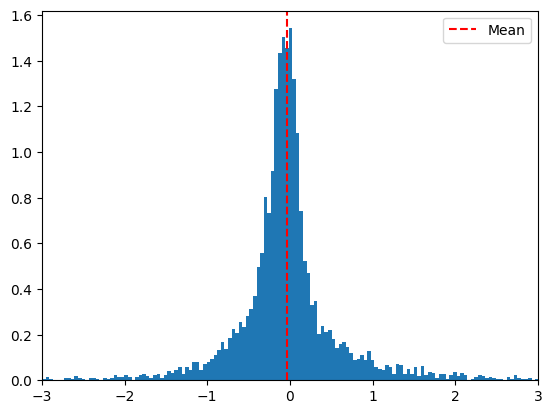

In [21]:
plt.hist(residuals, density=True, bins = 1000)
plt.axvline(residuals.mean(), color='r', linestyle='--', label='Mean')
plt.xlim(-3,3)
plt.legend()
plt.show()

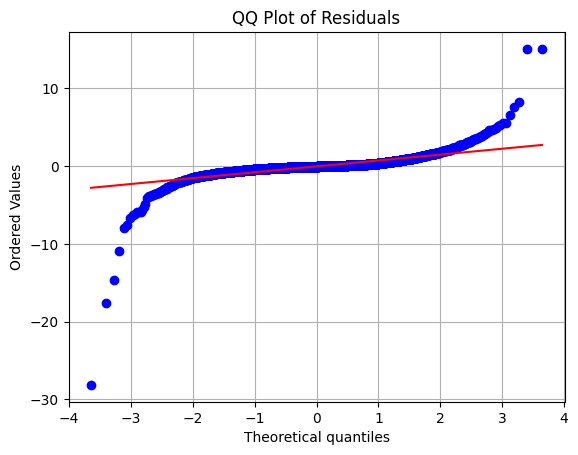

In [22]:
stats.probplot(residuals, dist = "norm", plot = plt)
plt.title("QQ Plot of Residuals")
plt.grid(True)
plt.show()

As we can see from the two plots above, while the histogram looks normally distributed, the QQ-plot tells us that it is in fact not normally distributed. If the residuals were normally distributed, then it would form a diagonal line, but here the tail ends significantly deviate from the diagonal line, indicating that the tails are heavier than those of a normal distribution.

## Hyperparameter search

To optimize the Neural Network model, we want to identify the best hyperparameter configuration which predicts the option's `mid_price` closest, to do this I will implement a randomized search. 

A few of the hyperparameters to optimize are: 
* Number of Hidden Layers
* Number of Neurons per layer
* Neuron activation function
* Neuron l2 regularization
* Learning rate
* Optimizer

To find the best configuration, we will select the number of hidden layers between 1 and 5, as adding more may be redundant. For the number of neurons, we will select a value between 10 and 100 neurons. Since deep neural networks often perform better with 'swish' activation rather than with 'ReLU', we will select the activation function between those two at random to assess which performs better. Our l2 regularizer and learning rate will both be chosen from a range between 1e-6 and 1e-2 to allow a broader range of values in which to assess performance on. Lastly, the optimizer will be selected at random as either the 'Adam' optimizer or the adam optimizer with nesterov momentum ('Nadam') to assess which fits the model better. Once again we will include early stopping to avoid unneccessary training, but this time with a patience of 5, as we will only be training on 20 epochs instead of 50 due to time constraints. This randomized search will run for 30 iterations in order to assess the optimal parameters, which we will then compare the best model here against the baseline model on their test set performance.

In [23]:
def reset_session(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    tf.keras.backend.clear_session()

def build_model(hp):
    reset_session()

    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape = (X_train.shape[1],)))

    n_hidden = hp.Int("n_hidden", 1, 5)
    for i in range(n_hidden):
        model.add(tf.keras.layers.Dense(
            hp.Int(f"n_neurons_{i+1}", 10, 100),
            activation = hp.Choice("activation", ["relu", 'swish']),
            kernel_regularizer = tf.keras.regularizers.l2(
            hp.Float("l2", 1e-6, 1e-2, sampling="log")
            ),
            kernel_initializer = "he_normal"
        ))
        
    model.add(tf.keras.layers.Dense(1))
    
    learning_rate = hp.Float("learning_rate", 1e-6, 1e-2, sampling = "log")
    optimizer_name = hp.Choice("optimizer", ["Adam", "Nadam"])
    
    if optimizer_name == "Adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
  
    model.compile(loss="mse", metrics = ['mae'], optimizer=optimizer)
    return model

early_stop = EarlyStopping(
    monitor = "val_loss",
    patience = 5,
    mode = "min",
    restore_best_weights = True
)

In [24]:
random_search_tuner = kt.RandomSearch(
    build_model, 
    objective = "val_loss", 
    seed = 42, 
    max_trials = 30, 
    overwrite = True
)

random_search_tuner.search(X_train_scaled, y_train, epochs = 20, 
                    validation_data = (X_valid_scaled, y_valid), verbose = 1,
                          callbacks=[early_stop])

Trial 30 Complete [00h 00m 39s]
val_loss: 1578.3851318359375

Best val_loss So Far: 1.8611531257629395
Total elapsed time: 00h 14m 31s


In [25]:
best_hyperparams = random_search_tuner.get_best_hyperparameters(num_trials = 1)[0]
best_hyperparams.values

{'n_hidden': 2,
 'n_neurons_1': 98,
 'activation': 'swish',
 'l2': 3.186250401134588e-06,
 'learning_rate': 0.005108567100824006,
 'optimizer': 'Adam',
 'n_neurons_2': 86,
 'n_neurons_3': 34,
 'n_neurons_4': 45,
 'n_neurons_5': 50}

In [26]:
best_model = build_model(best_hyperparams)

start = time.time()
history_best = best_model.fit(X_train_scaled, y_train,
             validation_data = (X_valid_scaled, y_valid),
             epochs = 50, verbose = 1, callbacks=[early_stop])
end = time.time()
tuned_model_time = end - start

test_loss_best, test_mae_best = best_model.evaluate(X_test_scaled, y_test)
print("\nTest MSE:", test_loss_best)
print("Test MAE:", test_mae_best)

Epoch 1/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 666.4120 - mae: 8.8387 - val_loss: 12.2135 - val_mae: 2.0019
Epoch 2/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.3149 - mae: 1.6530 - val_loss: 12.7953 - val_mae: 1.8484
Epoch 3/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.6964 - mae: 1.5122 - val_loss: 11.2003 - val_mae: 1.8442
Epoch 4/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.6256 - mae: 1.3839 - val_loss: 8.9317 - val_mae: 1.7305
Epoch 5/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.8799 - mae: 1.2951 - val_loss: 10.0164 - val_mae: 1.9773
Epoch 6/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.2325 - mae: 1.1999 - val_loss: 6.8492 - val_mae: 1.3887
Epoch 7/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.6602 - mae: 1.1072 - val_loss: 6.2827 - val_mae: 1.1938
Epoch 8/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.9618 - mae: 1.1404 - val_loss: 5.8417 - val_mae: 1.1182
Epoch 9/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/ste

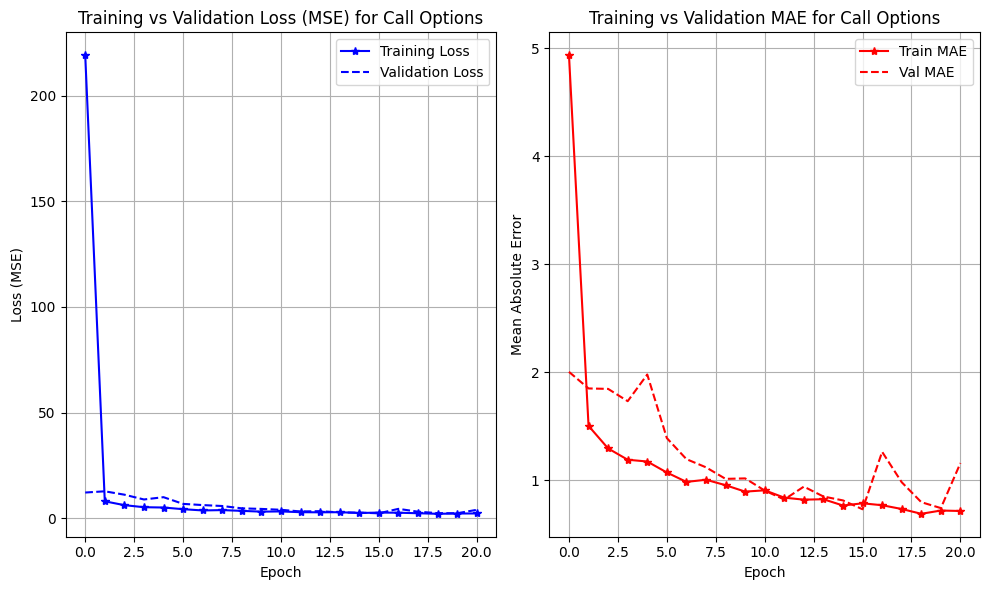

In [27]:
plot_learning_curves(history_best)

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


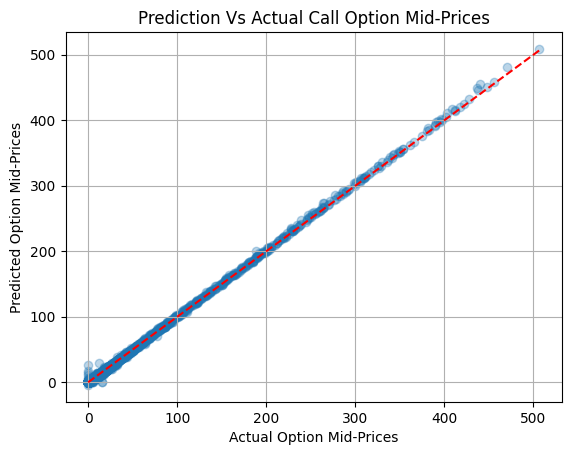

In [28]:
residuals = get_prediction_plot(best_model, X_test_scaled, 
                    y_test)

In [36]:
residuals.name = "residuals"
display(residuals.to_frame().describe())

,residuals
count,5178.000000
mean,0.073974
std,1.341234
min,-27.047512
25%,-0.262591
50%,-0.004782
75%,0.543655
max,15.007111


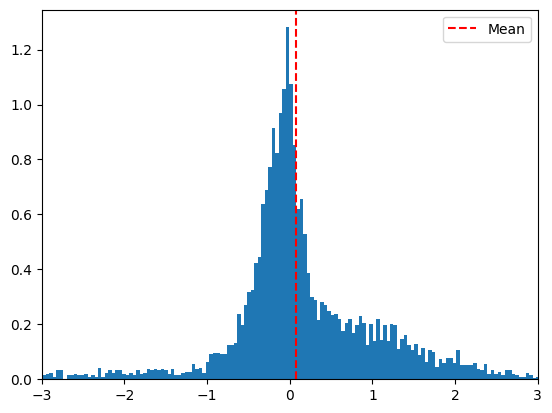

In [29]:
plt.hist(residuals, density=True, bins = 1000)
plt.axvline(residuals.mean(), color='r', linestyle='--', label='Mean')
plt.xlim(-3,3)
plt.legend()
plt.show()

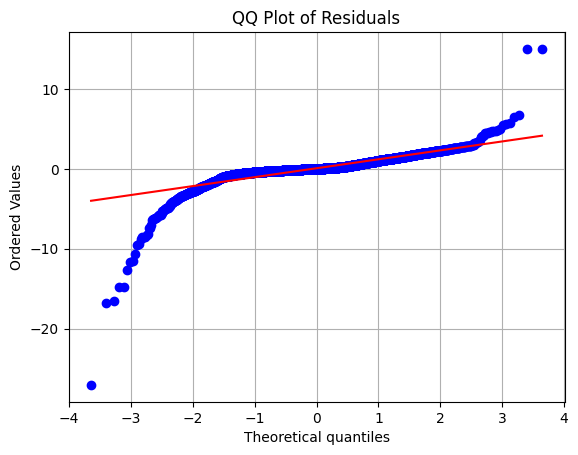

In [30]:
stats.probplot(residuals, dist = "norm", plot = plt)
plt.title("QQ Plot of Residuals")
plt.grid(True)
plt.show()

In [35]:
results_df = pd.DataFrame([
    {
        'Model': 'Baseline',
        'Layers': 4,
        'Activation': "relu",
        'Optimizer': "Nadam",
        'Epochs': max(history_baseline.epoch)+1,
        'Test MAE': round(test_mae, 4),
        'Test MSE': round(test_loss, 4),
        'Train Time (s)': round(baseline_time, 2)
    },
    {
        'Model': 'Tuned',
        'Layers': int(best_hyperparams['n_hidden']),
        'Activation': str(best_hyperparams['activation']),
        'Optimizer': str(best_hyperparams['optimizer']),
        'Epochs': max(history_best.epoch)+1,
        'Test MAE': round(test_mae_best, 4),
        'Test MSE': round(test_loss_best, 4),
        'Train Time (s)': round(tuned_model_time, 2)
    }
])

display(results_df)

,Model,Layers,Activation,Optimizer,Epochs,Test MAE,Test MSE,Train Time (s)
0,Baseline,4,relu,Nadam,50,0.4577,1.0024,70.73
1,Tuned,2,swish,Adam,21,0.7105,1.8089,28.23


As we can see from the plots above, the hyperparameter tuned model also doesn't seem to be overfitting as the training loss metrics converge nicely with the validation losses. The predictions seem to be slightly worse compared to the baseline model as we encounter more incorrectly estimated values around 0 based on the prediction plot. This can be reinforced from the test MSE and test MAE which were higher compared to the baseline model. 

Regardless, the hyperparameter tuned model seemed to use a different activation function and optimizer from the baseline model. Since the tuned model performed a lot worse after 50 epochs, this possibly indicates the baseline model's hyperparameters were better parameters than "swish" activation and "adam" optimizer we were evaluating against. The number of hidden layers in the tuned model was also less than the baseline model, which allowed for a faster training speed at the cost of  worse predictions. 

In summary, the hyperparameter optimization did not yield a significant improvement over our initial model architecture. This suggests that the baseline model was already well-suited for the task. For future work, we could build upon the baseline model by performing another randomized search, but this time focusing only on optimizing the l2 regularization and the learning rate parameters which could further improve the model's performance.

----

# Ilse's Model

# Gradient Boost

For my model, I chose Gradient Boosting for it's popularity in machine learning applications and it's relative speed compared to other more intensive models. Gradient boost focuses on fitting new predictors to residual errors made by the previous iteration, making it ideal for predicting the price of options. 

Starting with an initial model, we can generate a basic model with certain inital features, and see how good of a fit we get. We pick the inital features based on prior knowledge of Gradient Boosting regressors, as well as unseen iteration of the model to get a decent fit that runs in decent time. This method is not scientifically sound, but given the scope of the project, is used to better manage storage and time concerns. 

We expect the mean squared and mean absolute error to be better for the final model, but in the meantime, we can see how how the model behaves. 

In [54]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

gbrt = GradientBoostingRegressor(max_depth=5,
                                 n_estimators=120,
                                 learning_rate=0.5,
                                 n_iter_no_change=5,
                                 random_state=42)
gbrt.fit(X_train, y_train)
y_pred = gbrt.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean squared error of test set: {mse}')
print(f'Mean absolute error of test set: {mae}')

Mean squared error of test set: 15.184470115237183
Mean absolute error of test set: 1.8028649935523873


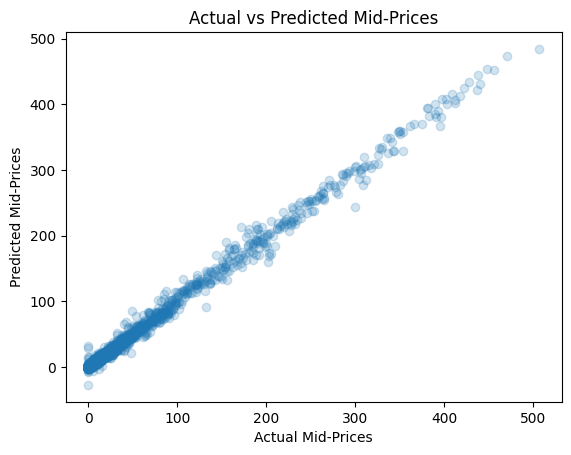

In [55]:
index = range(0, len(y_test))
plt.scatter(y_test, y_pred, alpha=0.2)
plt.xlabel("Actual Mid-Prices")
plt.ylabel("Predicted Mid-Prices")
plt.title('Actual vs Predicted Mid-Prices')
plt.show()

# Hyperparameter search

For hyperparameter tuning, we have a couple parameters that we can adjust for a better fit. 
- **n_estimators** is the number of predictors or trees within the ensemble
- **Learning_rate** scales the effect the previous predictor has in constructing the next predictor
- **n_iter_no_change** Helps prevent overfitting. If the previous *k* predictors have not improved the error, the model is stopped early. If this hyperparameter is too large, the model will overfit nonetheless, and thus needs to be chosen carefully. 

While another method such as GridSearchCV is available for hyperparameter tuning, the more systematic way is to adjust the learning rate, and find a good value of n_estimators that minimizes the error on the validation set. Additionally, gradient boost is prone to overfitting, and this approach will help to prevent such overfitting from occuring. In order to better serve this goal, we will use both the MSE and MAE to find the best model, as the MSE may end up being skewed by outlier error and MAE can provide better insight into the best gradient boosting model. 

We begin by finding the best learning parameter, assuming we fix the all other parameters from the initial model: 

In [56]:
for l in (0.05, 0.1, 0.3, 0.5, 0.7, 1.0):
    gbrt = GradientBoostingRegressor(max_depth=5, 
                                     learning_rate=l,
                                     n_iter_no_change=5,
                                     n_estimators=120, 
                                     random_state=42
    )
    gbrt.fit(X_train, y_train)

    gbrt.staged_predict(X_valid)
    errors = [mean_squared_error(y_valid, y_pred)
          for y_pred in gbrt.staged_predict(X_valid)]
    errs = [mean_absolute_error(y_valid, y_pred)
          for y_pred in gbrt.staged_predict(X_valid)]
    best_MSE = np.min(errors)
    best_MAE = np.min(errs)
    print()
    print(f'Learning rate: {l}')
    best_n_estimators = np.argmin(errors)+1
    best_n_est = np.argmin(errs)+1
    print('min MSE: {:.4f}, number of trees: {}'
          .format(best_MSE, best_n_estimators))
    print('min MAE: {:.4f}, number of trees: {}'
          .format(best_MAE, best_n_est))


Learning rate: 0.05
min MSE: 17.1671, number of trees: 120
min MAE: 1.9258, number of trees: 120

Learning rate: 0.1
min MSE: 9.2589, number of trees: 120
min MAE: 1.4828, number of trees: 120

Learning rate: 0.3
min MSE: 9.3207, number of trees: 120
min MAE: 1.4870, number of trees: 120

Learning rate: 0.5
min MSE: 14.4391, number of trees: 72
min MAE: 1.8743, number of trees: 73

Learning rate: 0.7
min MSE: 24.6811, number of trees: 47
min MAE: 2.3627, number of trees: 47

Learning rate: 1.0
min MSE: 59.4119, number of trees: 36
min MAE: 3.3466, number of trees: 43


Learning rate 0.1 has the smallest MSE and MAE, and as such, is the learning rate that will be used going forward. Now, we fix the learning rate, begin looking for the ideal number of estimators, based on both the MSE, MAE, and the previous learning rate search. We set *n_estimators* equal to 500 to give the model plenty of trees to use. 

In [57]:
gbrt = GradientBoostingRegressor(max_depth=5, 
                                 learning_rate=0.1,
                                 n_estimators=700, 
                                 n_iter_no_change=5,
                                 random_state=42)
gbrt.fit(X_train, y_train)

gbrt.staged_predict(X_valid)



errors = [mean_squared_error(y_valid, y_pred)
          for y_pred in gbrt.staged_predict(X_valid)]
errs = [mean_absolute_error(y_valid, y_pred)
          for y_pred in gbrt.staged_predict(X_valid)]
best_MSE = np.min(errors)
best_MAE = np.min(errs)
print()
print('Learning rate: 0.1')
best_n_estimators = np.argmin(errors)+1
best_n_est = np.argmin(errs)+1
print('min MSE: {:.4f}, number of trees: {}'
          .format(best_MSE, best_n_estimators))
print('min MAE: {:.4f}, number of trees: {}'
          .format(best_MAE, best_n_est))


Learning rate: 0.1
min MSE: 4.5681, number of trees: 668
min MAE: 0.9852, number of trees: 669


From here, we have a couple differnt values we can use for the *n_estimator*. can see we have two different values for the number of trees to use in the best model. As such, we can build both models, and compare the MSE and MAE of each to see what produces the best model, and fit other hyperparameters based on this.

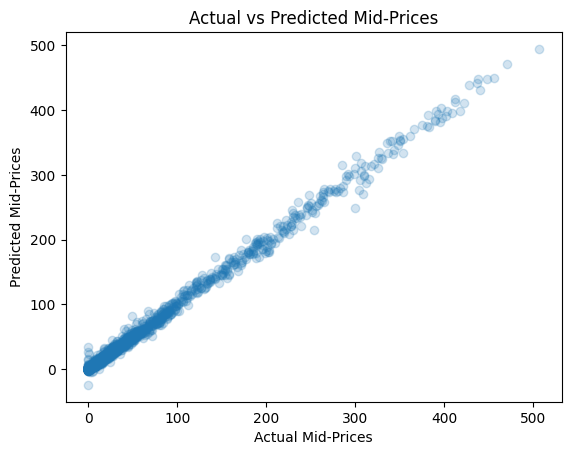

Mean squared error of test set: 10.751143884684343
Mean absolute error of test set: 1.4942072433787403


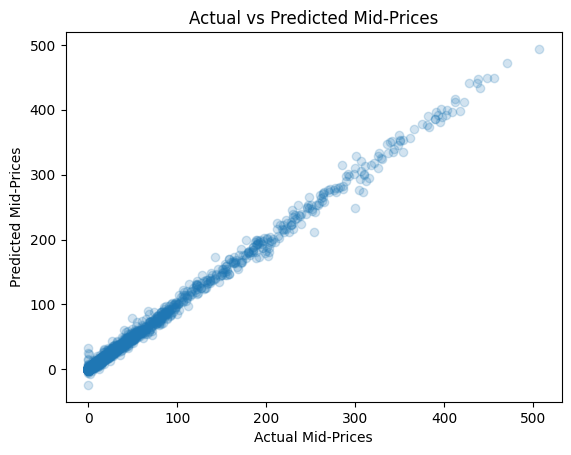

Mean squared error of test set: 9.635986755498594
Mean absolute error of test set: 1.3596889684030113


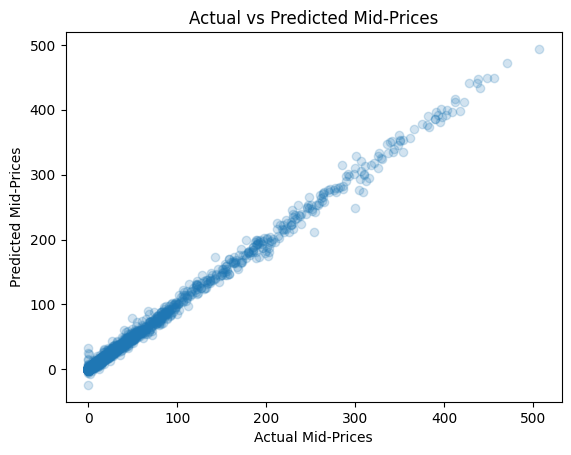

Mean squared error of test set: 9.635986755498594
Mean absolute error of test set: 1.3596889684030113


In [58]:
y_pred = []
for param, i in zip([120, 668, 669], range(0, 3)):
    test_model = GradientBoostingRegressor(max_depth=5, 
                                           learning_rate=0.3,
                                           n_estimators=param, 
                                           n_iter_no_change=5,
                                           random_state=42)

    test_model.fit(X_train, y_train)
    pred = test_model.predict(X_test)
    y_pred.append(pred)

index = range(0, len(y_test))
for pred in y_pred:
    plt.scatter(y_test, pred, alpha=0.2)
    plt.xlabel("Actual Mid-Prices")
    plt.ylabel("Predicted Mid-Prices")
    plt.title('Actual vs Predicted Mid-Prices')
    plt.show()
    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    print(f'Mean squared error of test set: {mse}')
    print(f'Mean absolute error of test set: {mae}')

The visible MSE and MAE for two of the *n_estimators* is visibly identical, and as such, implies that there may be a problem with the parameter *n_iter_o_change*. In conjunction with the small difference in MSE, and especially MAE with 120 *n_estimators* compared to 668 *n_estimators*, this is supported further. 

In [59]:
best_model_mse = GradientBoostingRegressor(max_depth=5, 
                                           learning_rate=0.5,
                                           n_estimators=668, 
                                           n_iter_no_change=5,
                                           random_state=42)
%time best_model_mse.fit(X_train, y_train)

y_pred = best_model_mse.predict(X_test)

CPU times: user 4.24 s, sys: 31.9 ms, total: 4.27 s
Wall time: 4.33 s


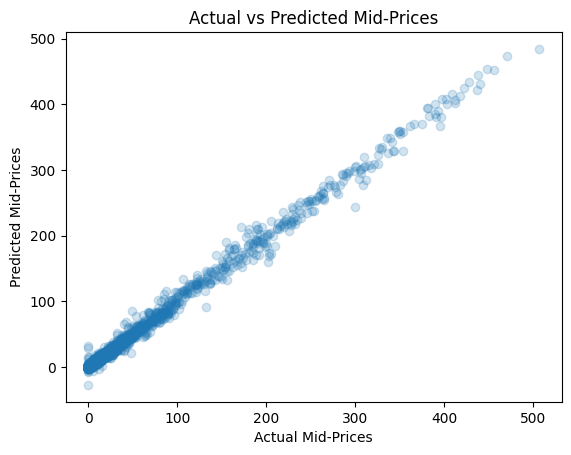

In [60]:
index = range(0, len(y_test))
plt.scatter(y_test, y_pred, alpha=0.2)
plt.xlabel("Actual Mid-Prices")
plt.ylabel("Predicted Mid-Prices")
plt.title('Actual vs Predicted Mid-Prices')
plt.show()

In [61]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean squared error of test set: {mse}')
print(f'Mean absolute error of test set: {mae}')

Mean squared error of test set: 15.184470115237183
Mean absolute error of test set: 1.8028649935523873


Based on the results, I think it's very possible the model is overfitting, especially given the more miniscule changes in the MSE and MAE, and indeed Gradient Boosting has more hyperparameters that could be changed, and more fitting that can be done to provide a better model, beyond what's shown in this report. However, given what's shown, Gradient Boost could potentially make a decent model for option prediction, but more work would be needed to say for certain. However, in comparison to other models, the MSE and MAE are much larger, marking Gradient Boosting as a potentially bad algorithm to use for this kind of application.

----

# Jasmine's Model - k-NN Regression

--

# Model Selection

For this task, I decided to use a k-NN regressor for its simplicity and speed, and its ability to work well with enough well-engineered feature data. Furthermore, despite being relatively lightweight and simple, it can still model nonlinear relationships; although, it's not great at extrapolation and is slow for large datasets. To try and increase the model's speed on our large dataset, I first apply PCA to reduce the dimensionality of the dataset before training the model.

I selected the k-NN regressor for several reasons:
1. k-NN is a non-parametric model, which is useful in American option pricing where no assumptions about the underlying functional form of the data is a benefit. Since the payoff structure and early exercise features can introduce nonlinear and path-dependent behaviors that are difficult to model with linear models, a non-parametric model like k-NN could improve price prediction performance.
2. k-NN is able to measure local similarity between features, and then makes predictions based on neighboring historical points. This local interpolation approach is effective amd more well-suited in financial data where similar market conditions often result in similar pricing behavior.
3. k-NN is simple to implement, interpretable, and robust to noisy targets, which are all beneficial in modeling complex financial dynamics. It's also multivariate and can, as stated above, handle nonlinear interactions between features without needing to explicitly model them.

Some drawdowns are:
1. k-NN can be computationally expensive and slow, especially for large datasets
2. It performs poorly with irrelevant or redundant features
3. It does not extrapolate well outside the training data

To address these concerns, I:
1. Will use PCA to reduce the dimensionality of the dataset before training the k-NN model to improve both speed and generalization performance.
2. Tune the hyperparameters (using RandomizedSearchCV) to carefully optimize the parameters in a way that ensures the model is more aptly fit for the structure of the feature space.

In summary, while k-NN is a relatively simple model, it has advantages in its combination of speed, interpretability, and flexibility making it a strong base model especially when paired with preprocessing methods like PCA and hyperparameter tuning.

# Base k-NN Regression Call Option Model (No Hyperparameter Tuning)

Pipeline Design:
1. Numerical pipeline
    * SimpleImputer with median imputation is robust to outliers, which is better suited for cleaning financial or pricing data
    * StandardScaler ensures all numeric features have mean 0 and unit variance, which is important for distance-based models like k-NN
    * PCA (retaining 95% variance) to avoid curse of dimensionality and reduce model runtime
2. Categorical Pipeline:
    * SimpleImputer replaces missing values with most frequent category to avoid data leakage and retain most common patterns in the data
    * OneHotEncoder to encode categorical variables into binary values, which is necessary for a model like K-NN that cannot handle non-numeric inputs.

Metrics Used:
1. RMSE to measure prediction accuracy while penalizing large errors more heavily, well-suited for our problem of mid-price forecasting. However, it can also exaggerate the impact of outliers.
2. MAE to give a second metric that is more robust to outliers and a more interpretable measure of average prediction error especially when dealing with the same units (e.g. we're using dollars to predict mid-prices, and that unit stays the same).

Test RMSE (with PCA): 6.7230
Test MAE (with PCA): 2.4744


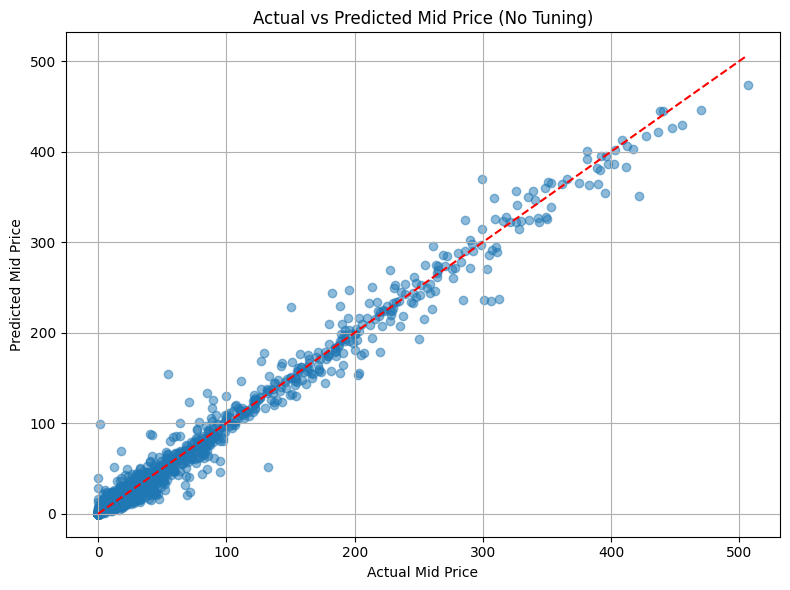

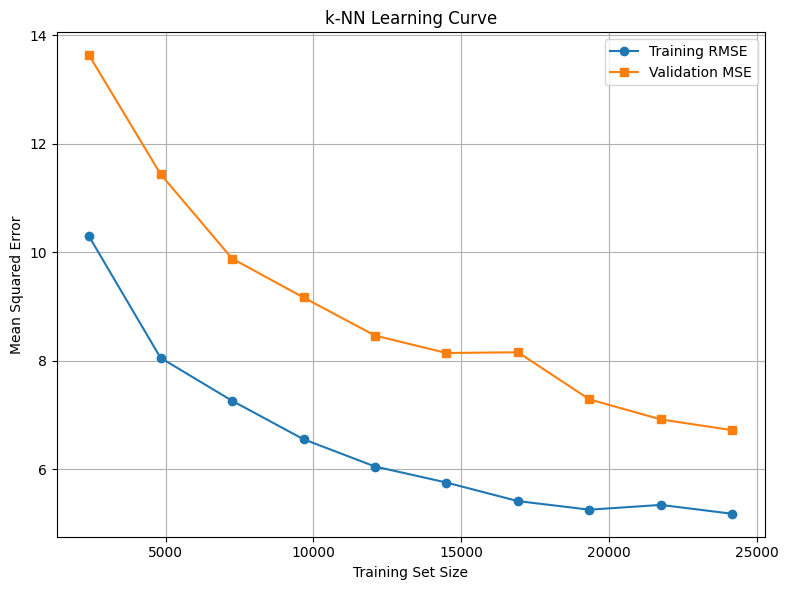

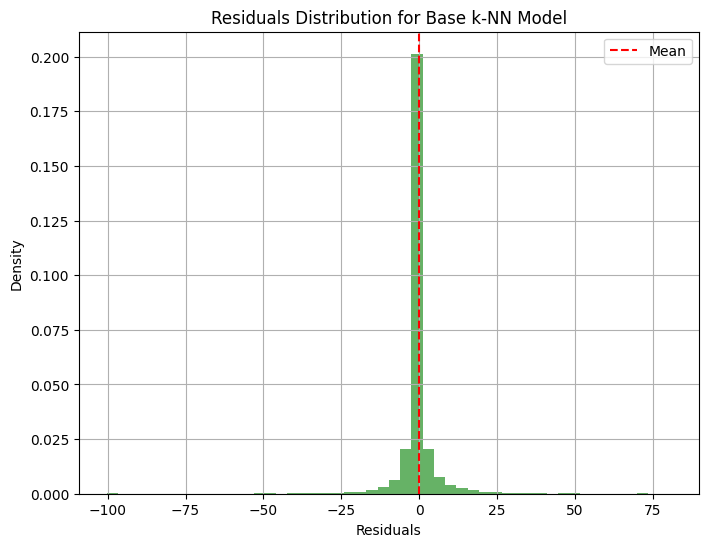

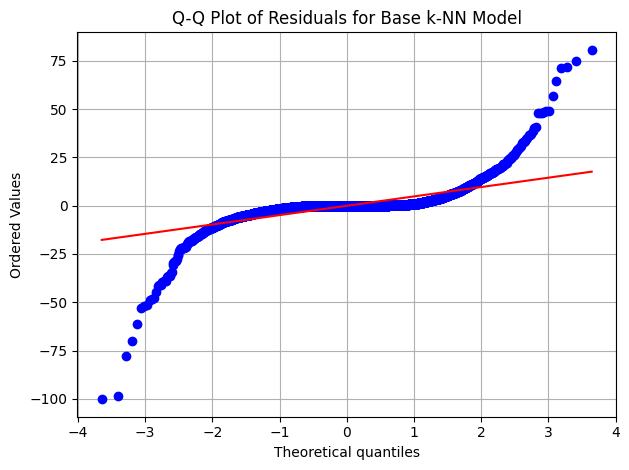

In [62]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer
import numpy as np
import matplotlib.pyplot as plt


# Identifying column types for preprocessing
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()


# Define preprocessing pipelines for numerical and categorical features
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95))  # PCA to reduce dimensionality while retaining 95% variance
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Full pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsRegressor(n_neighbors=5))
])

# Fit the full pipeline
pipeline.fit(X_train, y_train)

# Predict and evaluate using RMSE
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Test RMSE (with PCA): {np.sqrt(mse):.4f}")
print(f"Test MAE (with PCA): {mae:.4f}")


# Plot the actuals v.s. predicted values to determine if model is over/under-fitting -------
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Mid Price")
plt.ylabel("Predicted Mid Price")
plt.title("Actual vs Predicted Mid Price (No Tuning)")
plt.grid(True)
plt.tight_layout()
plt.show()


# Plot the validation and training learning curve -------

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_test)

y_val = y_test.values

# Loop through training set sizes
train_sizes = np.linspace(0.1, 1.0, 10)
train_errors = []
val_errors = []

for size in train_sizes:
    subset_size = int(size * len(X_train_preprocessed))
    
    X_subset = X_train_preprocessed[:subset_size]
    y_subset = y_train[:subset_size]

    knn = KNeighborsRegressor(n_neighbors=5)
    knn.fit(X_subset, y_subset)

    y_train_pred = knn.predict(X_subset)
    y_val_pred = knn.predict(X_val_preprocessed)

    train_rmse = np.sqrt(mean_squared_error(y_subset, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    train_errors.append(train_rmse)
    val_errors.append(val_rmse)

# Plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes * len(X_train_preprocessed), train_errors, label='Training RMSE', marker='o')
plt.plot(train_sizes * len(X_train_preprocessed), val_errors, label='Validation MSE', marker='s')
plt.xlabel("Training Set Size")
plt.ylabel("Mean Squared Error")
plt.title("k-NN Learning Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate the residuals of the base model
base_residuals = y_test - y_pred
# Plot the residuals
plt.figure(figsize=(8, 6))
plt.hist(base_residuals, bins=50, density=True, alpha=0.6, color='g')
plt.axvline(residuals.mean(), color='r', linestyle='--', label='Mean')
plt.title("Residuals Distribution for Base k-NN Model")
plt.xlabel("Residuals")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

# Q-Q plot for the residuals of the base model
stats.probplot(base_residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals for Base k-NN Model")
plt.grid(True)
plt.tight_layout()
plt.show()

What does this say about the base k-NN model?

Bias:
* Low -- we can see this from the residual distribution plot, where many points are centered around 0, suggesting that the model is unbiased on average.

Variance:
* Moderate -- the model has a sharp peak in the residual distribution but heavy tails

Outlier Sensitivity:
* High -- the model has a long-tailed residual distribution, and a high RMSE-MAE gap

Fit Quality:
* As seen in the scatter plot, it is a good baseline model that can capture a general relationship between the features and target, but it is sensitive to extreme outliers or variance in the predictions (and in the RMSE-MAE gap).

Over/Under-fitting:
* Both the Training and Validation RMSEs decrease steadily as training size increases, eventually leveling out at around 5.5. 
* Underfitting does not seem to be a problem here as the training error is quite low
* However, the gap between the curves starts fairly large which suggests overfitting and does not decrease significantly as the training size increases. The overfitting is not extreme though, as evidenced by the way the validation error is consistently higher than the training error but not by a significant amount.


# k-NN Regression Call Option Model with Hyperparameter Tuning

Hyperparameter Choice:
1. `n_neighbors` controls the bias-variance trade-off. If we choose a lower k, that is the algorithm considers fewer neighbor to classify new data points, we can capture much finer details in the dataset. This is low bias, high variance, and is prone to overfitting to noise in the training set. A higher k considers more neighbors to classify new data points and thus smooths out noise. This is high bias, low variance, which leads to more stable model performance but is prone to underfitting and averaging over too many points. Thus, tuning this hyperparameter is important in making sure we have the best bias-variance trade-off.
2. `weights` allows the model to find the optimal way of weighting neighbors depending on the data distribution. The 'distance' metric can improve performance when nearby points are more informative, while the 'uniform' metric assumes all neighbors contribute equally. It would be important for us to tune this hyperparameter to find which metric most accurately captures the underlying relationships of our dataset.
3. `p` (distance metric), allows the model to find the optimal "closeness" in a feature space. The Manhattan metric is more robust to high-dimensional datasets, while the Euclidean metric is more sensitive to outliers. Tuning this hyperparameter can improve model performance when the features are on different scales or distributions.

Search Algorithm:

* `RandomizedSearchCV`
    * Efficiency: More computationally feasible and faster than GridSearchCV for large datasets
    * Wider range of exploration: Covers a broad range of combinations randomly
Since we have a larger dataset, RandomizedSearchCV seems more well-suited to our problem than GridSearchCV.

In summary, our hyperparameter choices ensures our k-NN model is tuned for bias-variance trade-off and feature distributions. Distance weighting and metric choice also improves model performance when the data has a non-uniform strucutre or nonlinear patterns, which our dataset certainly has. And finally, since our dataset is quite large, we choose RandomizedSearchCV over GridSearchCV to improve model efficiency.

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[CV] END .knn__n_neighbors=9, knn__p=2, knn__weights=uniform; total time=   0.1s
[CV] END .knn__n_neighbors=9, knn__p=2, knn__weights=uniform; total time=   0.1s
[CV] END .knn__n_neighbors=9, knn__p=2, knn__weights=uniform; total time=   0.1s
[CV] END .knn__n_neighbors=9, knn__p=2, knn__weights=uniform; total time=   0.1s
[CV] END .knn__n_neighbors=9, knn__p=2, knn__weights=uniform; total time=   0.1s
[CV] END knn__n_neighbors=17, knn__p=1, knn__weights=distance; total time=   0.2s
[CV] END knn__n_neighbors=17, knn__p=1, knn__weights=distance; total time=   0.2s
[CV] END knn__n_neighbors=23, knn__p=1, knn__weights=distance; total time=   0.1s
[CV] END knn__n_neighbors=23, knn__p=1, knn__weights=distance; total time=   0.2s
[CV] END knn__n_neighbors=23, knn__p=1, knn__weights=distance; total time=   0.2s
[CV] END knn__n_neighbors=21, knn__p=1, knn__weights=uniform; total time=   0.2s
[CV] END knn__n_neighbors=17, knn__p=1, knn__weights=distance; total time=   0.2s[CV] END knn__n_neighbo

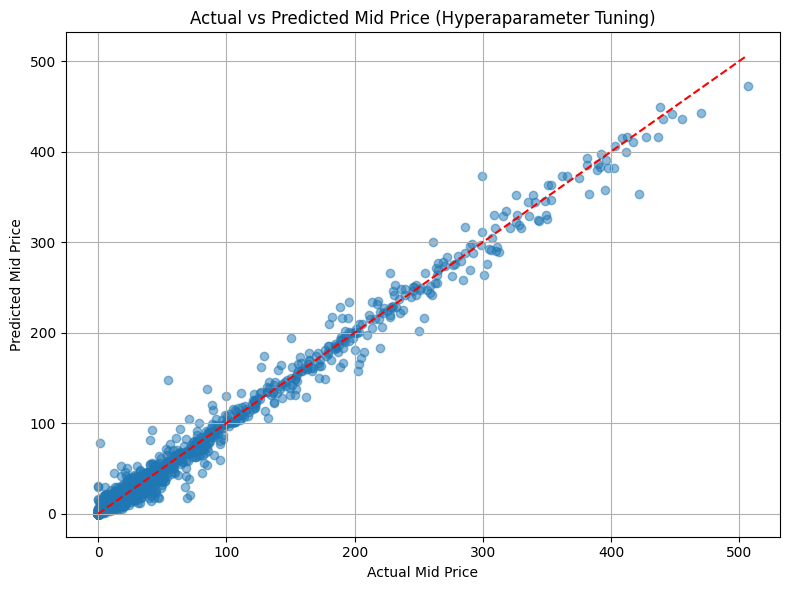

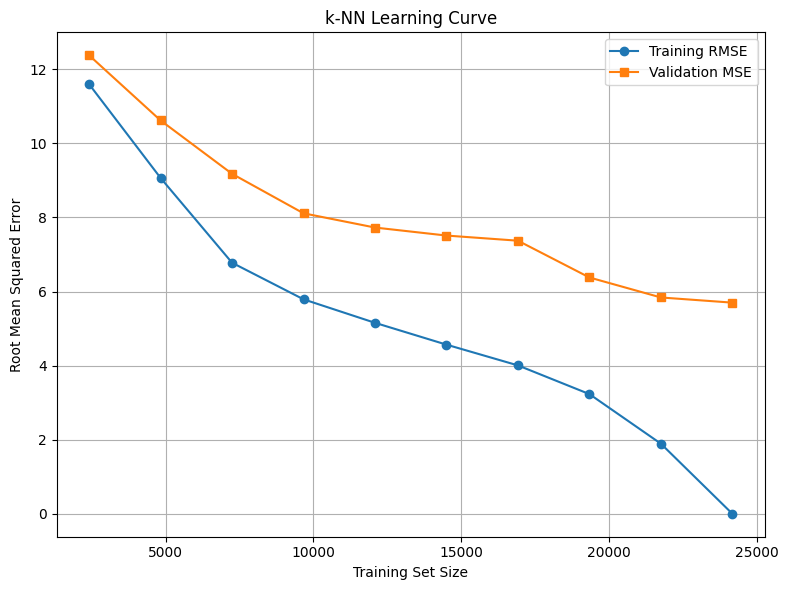

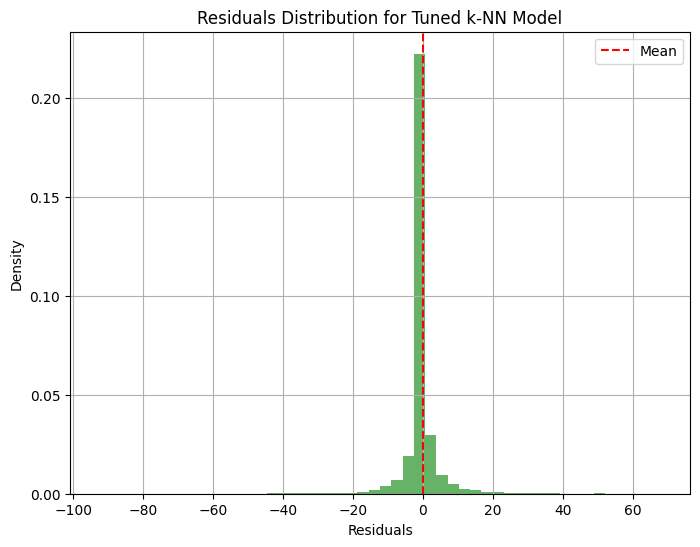

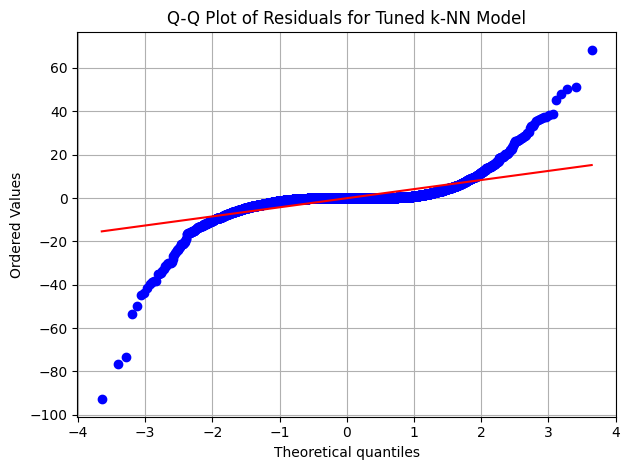

In [63]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


param_dist = {
    'knn__n_neighbors': randint(3, 30),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2],  # 1=Manhattan, 2=Euclidean
}

random_search_mse = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

random_search_mse.fit(X_train, y_train)

print("Best parameters found:", random_search_mse.best_params_)
print("Best CV RMSE:", np.sqrt(-random_search_mse.best_score_))

# Use the best model for prediction
best_knn_model = random_search_mse.best_estimator_
y_tuned_pred = best_knn_model.predict(X_test)

best_params = random_search_mse.best_params_
best_k = best_params['knn__n_neighbors']
best_weights = best_params['knn__weights']
best_p = best_params['knn__p']

# Store training and validation scores to plot
y_train_pred = best_knn_model.predict(X_train)
y_valid_pred = best_knn_model.predict(X_valid)


mse = mean_squared_error(y_test, y_tuned_pred)
mae = np.mean(np.abs(y_test - y_tuned_pred))
print(f"Test RMSE with best parameters: {np.sqrt(mse):.4f}")
print(f"Test MAE with best parameters: {mae:.4f}")


# Plot the actuals v.s. predicted values -------
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_tuned_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Mid Price")
plt.ylabel("Predicted Mid Price")
plt.title("Actual vs Predicted Mid Price (Hyperaparameter Tuning)")
plt.grid(True)
plt.tight_layout()
plt.show()


# Plot the validation and training learning curve -------

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_test)

y_val = y_test.values

train_sizes = np.linspace(0.1, 1.0, 10)
train_errors = []
val_errors = []

for size in train_sizes:
    subset_size = int(size * len(X_train_preprocessed))
    
    X_subset = X_train_preprocessed[:subset_size]
    y_subset = y_train[:subset_size]

    best_knn = KNeighborsRegressor(n_neighbors=best_k, weights=best_weights, p=best_p)  # Use the best KNN model from the random search
    best_knn.fit(X_subset, y_subset)

    y_train_pred = best_knn.predict(X_train_preprocessed)
    y_val_pred = best_knn.predict(X_val_preprocessed)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    train_errors.append(train_rmse)
    val_errors.append(val_rmse)

# Plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes * len(X_train_preprocessed), train_errors, label='Training RMSE', marker='o')
plt.plot(train_sizes * len(X_train_preprocessed), val_errors, label='Validation MSE', marker='s')
plt.xlabel("Training Set Size")
plt.ylabel("Root Mean Squared Error")
plt.title("k-NN Learning Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate the residuals of the tuned model
tuned_residuals = y_test - y_tuned_pred
# Plot the residuals
plt.figure(figsize=(8, 6))
plt.hist(tuned_residuals, bins=50, density=True, alpha=0.6, color='g')
plt.axvline(residuals.mean(), color='r', linestyle='--', label='Mean')
plt.title("Residuals Distribution for Tuned k-NN Model")
plt.xlabel("Residuals")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

# Q-Q plot for the residuals of the tuned model
stats.probplot(tuned_residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals for Tuned k-NN Model")
plt.grid(True)
plt.tight_layout()
plt.show()



What improvements do we see in the tuned k-NN model?

RMSE: 
* 6.723 -> 5.7004. 
* Lower RMSE, suggesting better fit, and fewer large errors.

MAE:
* 2.4744 -> 2.1559.
* Lower MAE, suggesting better average performance.

Residual skew:
* Slight right skew -> A little more right-skewed
* This suggests that the model tends to predict that the mid-prices are lower than they actually are, which may be indicative of it struggling to predict higher-priced options.

Q-Q plot:
* Stronger tail deviations -> Slightly tighter tails, closer to the line
* Suggests reduced kurtosis and outlier impact on model

Learning Curves:
* Training-Validation Error gap starts big, gradually declines -> Training-Validation error starts small, gradually gets bigger and training error goes to zero
* Suggests strong over-fitting and a model that is too flexible and under-regularized. Furthermore, the training error going to zero suggests that the model is memorizing the training data, which can happen with small k.

In summary, the tuned k-NN model maintains high consistency and predictive strength, but struggles with higher-priced options and extreme overfitting.


# Conclusions for k-NN Model

Model Performance Summary:
* After tuning the model using RandomizedSearchCV, the best performing k-NN model achieved an RMSE of 5.7004 and MAE of 2.1559.
* The low MAE and actuals v.s. predicted scatter plot indicates that the model is able to capture general relationships between the input features and the target
* But the RMSE-MAE gap and heavy-tailed residual distributions suggest that model performance deteriorates when predicting higher-priced options
* Furthermore, the learning curves suggests that the model struggles with the issue of overfitting

Final Assessment:
In conclusion, the k-NN regression model, even with dimensionality reduction (PCA) and hyperparameter tuning, shows a limited capacity to generalize to out-of-sample data and suffers from overfitting due to its memory-based structure. While it remains a good starting model and provides a baseline level of accuracy as shown with its low MAE, its performance is significantly worse when faced with outliers and skewed data distributions. Thus, while a fast and easy-to-implement benchmark model, k-NN is not the most appropriate choice for modeling American call options, and models such as Random Forests, GBMs, and Neural Networks (as explored in this project) are recommended.


----

# Conclusions